# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

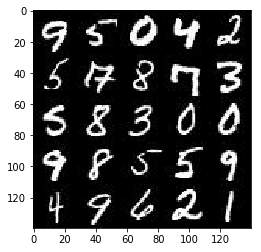

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

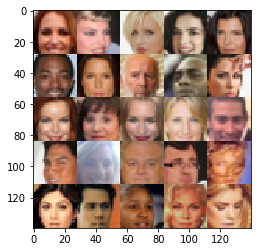

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_height, image_width, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate', shape=())

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):

        alpha = 0.2

        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        # 7x7x256 now

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now

        out = tf.tanh(logits)

        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
        return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Need to first map the input_real dims to data_shape
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    ### Build GAN
    # Define Model_Inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Define Model_Loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Define Model_Opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    ### Training
    n_total_batches = data_shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            batch_counter = 0
            
            for batch_images in get_batches(batch_size):
                batch_counter += 1
                
                # Need to first scale real image values from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images*2.0
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                              input_z: batch_z,
                                              lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                # For each 10 batches, get the losses and print them out
                if batch_counter % 10 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} - Batch {}/{}: ".format(e+1, epoch_count, batch_counter, n_total_batches),
                         "Discriminator loss = {:.4f} ".format(d_train_loss),
                         "Generator loss = {:.4f}".format(g_train_loss))
                    
                # Show generator output samples so we can see the progress during training
                if batch_counter % 100 == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Batch 10/1875:  Discriminator loss = 0.5598  Generator loss = 2.8149
Epoch 1/2 - Batch 20/1875:  Discriminator loss = 0.7065  Generator loss = 2.1642
Epoch 1/2 - Batch 30/1875:  Discriminator loss = 3.0336  Generator loss = 0.1266
Epoch 1/2 - Batch 40/1875:  Discriminator loss = 1.8498  Generator loss = 4.9224
Epoch 1/2 - Batch 50/1875:  Discriminator loss = 1.1872  Generator loss = 0.8707
Epoch 1/2 - Batch 60/1875:  Discriminator loss = 0.4892  Generator loss = 2.5430
Epoch 1/2 - Batch 70/1875:  Discriminator loss = 1.1097  Generator loss = 0.8056
Epoch 1/2 - Batch 80/1875:  Discriminator loss = 1.6674  Generator loss = 0.4534
Epoch 1/2 - Batch 90/1875:  Discriminator loss = 0.9359  Generator loss = 1.2284
Epoch 1/2 - Batch 100/1875:  Discriminator loss = 1.4979  Generator loss = 0.5121


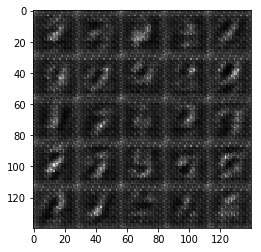

Epoch 1/2 - Batch 110/1875:  Discriminator loss = 0.6950  Generator loss = 1.5498
Epoch 1/2 - Batch 120/1875:  Discriminator loss = 0.7377  Generator loss = 2.1698
Epoch 1/2 - Batch 130/1875:  Discriminator loss = 0.8177  Generator loss = 1.2428
Epoch 1/2 - Batch 140/1875:  Discriminator loss = 0.8432  Generator loss = 1.0464
Epoch 1/2 - Batch 150/1875:  Discriminator loss = 0.8293  Generator loss = 2.7188
Epoch 1/2 - Batch 160/1875:  Discriminator loss = 1.3304  Generator loss = 0.5535
Epoch 1/2 - Batch 170/1875:  Discriminator loss = 0.6931  Generator loss = 1.5743
Epoch 1/2 - Batch 180/1875:  Discriminator loss = 0.7012  Generator loss = 2.3166
Epoch 1/2 - Batch 190/1875:  Discriminator loss = 0.7366  Generator loss = 1.3692
Epoch 1/2 - Batch 200/1875:  Discriminator loss = 1.4761  Generator loss = 5.1209


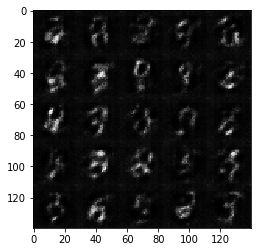

Epoch 1/2 - Batch 210/1875:  Discriminator loss = 0.7337  Generator loss = 2.4665
Epoch 1/2 - Batch 220/1875:  Discriminator loss = 0.9298  Generator loss = 0.9258
Epoch 1/2 - Batch 230/1875:  Discriminator loss = 0.8609  Generator loss = 2.8815
Epoch 1/2 - Batch 240/1875:  Discriminator loss = 0.6341  Generator loss = 2.1427
Epoch 1/2 - Batch 250/1875:  Discriminator loss = 0.9177  Generator loss = 3.4723
Epoch 1/2 - Batch 260/1875:  Discriminator loss = 0.6909  Generator loss = 2.3242
Epoch 1/2 - Batch 270/1875:  Discriminator loss = 0.7552  Generator loss = 1.8731
Epoch 1/2 - Batch 280/1875:  Discriminator loss = 0.6630  Generator loss = 1.8683
Epoch 1/2 - Batch 290/1875:  Discriminator loss = 0.7820  Generator loss = 1.2088
Epoch 1/2 - Batch 300/1875:  Discriminator loss = 0.6482  Generator loss = 1.9430


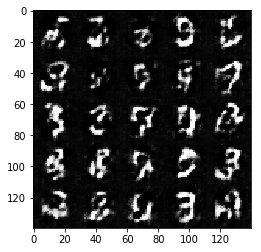

Epoch 1/2 - Batch 310/1875:  Discriminator loss = 0.7242  Generator loss = 2.6120
Epoch 1/2 - Batch 320/1875:  Discriminator loss = 1.0070  Generator loss = 3.8835
Epoch 1/2 - Batch 330/1875:  Discriminator loss = 0.8018  Generator loss = 3.4299
Epoch 1/2 - Batch 340/1875:  Discriminator loss = 0.7946  Generator loss = 1.2493
Epoch 1/2 - Batch 350/1875:  Discriminator loss = 1.4201  Generator loss = 0.5413
Epoch 1/2 - Batch 360/1875:  Discriminator loss = 1.1204  Generator loss = 0.7912
Epoch 1/2 - Batch 370/1875:  Discriminator loss = 0.6454  Generator loss = 1.6753
Epoch 1/2 - Batch 380/1875:  Discriminator loss = 0.6411  Generator loss = 2.4750
Epoch 1/2 - Batch 390/1875:  Discriminator loss = 0.8396  Generator loss = 1.2784
Epoch 1/2 - Batch 400/1875:  Discriminator loss = 0.5244  Generator loss = 2.1907


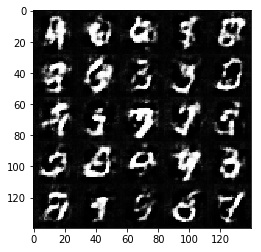

Epoch 1/2 - Batch 410/1875:  Discriminator loss = 0.5293  Generator loss = 2.0722
Epoch 1/2 - Batch 420/1875:  Discriminator loss = 0.6926  Generator loss = 1.4831
Epoch 1/2 - Batch 430/1875:  Discriminator loss = 0.6437  Generator loss = 2.7329
Epoch 1/2 - Batch 440/1875:  Discriminator loss = 0.7513  Generator loss = 1.2534
Epoch 1/2 - Batch 450/1875:  Discriminator loss = 1.4885  Generator loss = 0.6165
Epoch 1/2 - Batch 460/1875:  Discriminator loss = 0.6398  Generator loss = 1.6665
Epoch 1/2 - Batch 470/1875:  Discriminator loss = 0.5432  Generator loss = 2.1603
Epoch 1/2 - Batch 480/1875:  Discriminator loss = 0.6700  Generator loss = 2.8496
Epoch 1/2 - Batch 490/1875:  Discriminator loss = 0.9197  Generator loss = 0.9912
Epoch 1/2 - Batch 500/1875:  Discriminator loss = 0.5621  Generator loss = 2.7879


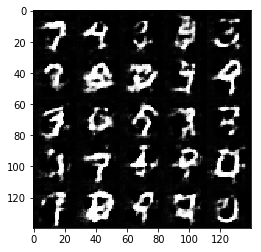

Epoch 1/2 - Batch 510/1875:  Discriminator loss = 1.1560  Generator loss = 0.7031
Epoch 1/2 - Batch 520/1875:  Discriminator loss = 0.8719  Generator loss = 1.2708
Epoch 1/2 - Batch 530/1875:  Discriminator loss = 0.7407  Generator loss = 1.3014
Epoch 1/2 - Batch 540/1875:  Discriminator loss = 0.8025  Generator loss = 1.1570
Epoch 1/2 - Batch 550/1875:  Discriminator loss = 0.5900  Generator loss = 2.0402
Epoch 1/2 - Batch 560/1875:  Discriminator loss = 3.0937  Generator loss = 0.1197
Epoch 1/2 - Batch 570/1875:  Discriminator loss = 0.7126  Generator loss = 1.5074
Epoch 1/2 - Batch 580/1875:  Discriminator loss = 0.6166  Generator loss = 1.7104
Epoch 1/2 - Batch 590/1875:  Discriminator loss = 0.8150  Generator loss = 1.2489
Epoch 1/2 - Batch 600/1875:  Discriminator loss = 0.8999  Generator loss = 1.0023


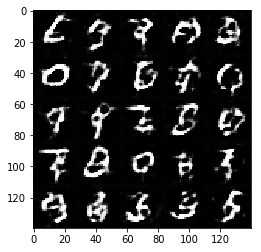

Epoch 1/2 - Batch 610/1875:  Discriminator loss = 0.6927  Generator loss = 1.3818
Epoch 1/2 - Batch 620/1875:  Discriminator loss = 0.6832  Generator loss = 1.5788
Epoch 1/2 - Batch 630/1875:  Discriminator loss = 0.5987  Generator loss = 1.8359
Epoch 1/2 - Batch 640/1875:  Discriminator loss = 1.0618  Generator loss = 0.8331
Epoch 1/2 - Batch 650/1875:  Discriminator loss = 1.2504  Generator loss = 0.8167
Epoch 1/2 - Batch 660/1875:  Discriminator loss = 0.8722  Generator loss = 1.1218
Epoch 1/2 - Batch 670/1875:  Discriminator loss = 0.7567  Generator loss = 1.3172
Epoch 1/2 - Batch 680/1875:  Discriminator loss = 0.5880  Generator loss = 2.1269
Epoch 1/2 - Batch 690/1875:  Discriminator loss = 0.7626  Generator loss = 1.8650
Epoch 1/2 - Batch 700/1875:  Discriminator loss = 0.6855  Generator loss = 1.9209


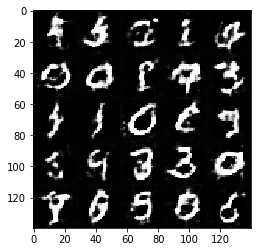

Epoch 1/2 - Batch 710/1875:  Discriminator loss = 0.7962  Generator loss = 1.2498
Epoch 1/2 - Batch 720/1875:  Discriminator loss = 1.7123  Generator loss = 0.4041
Epoch 1/2 - Batch 730/1875:  Discriminator loss = 0.9237  Generator loss = 1.0762
Epoch 1/2 - Batch 740/1875:  Discriminator loss = 0.7328  Generator loss = 1.3605
Epoch 1/2 - Batch 750/1875:  Discriminator loss = 0.6937  Generator loss = 1.7542
Epoch 1/2 - Batch 760/1875:  Discriminator loss = 0.6662  Generator loss = 1.6038
Epoch 1/2 - Batch 770/1875:  Discriminator loss = 0.7691  Generator loss = 1.2461
Epoch 1/2 - Batch 780/1875:  Discriminator loss = 0.6229  Generator loss = 1.8265
Epoch 1/2 - Batch 790/1875:  Discriminator loss = 1.1308  Generator loss = 0.7281
Epoch 1/2 - Batch 800/1875:  Discriminator loss = 0.6751  Generator loss = 1.6206


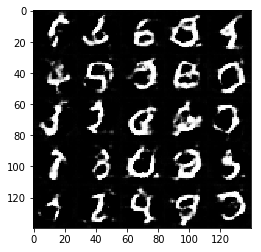

Epoch 1/2 - Batch 810/1875:  Discriminator loss = 3.6211  Generator loss = 0.0712
Epoch 1/2 - Batch 820/1875:  Discriminator loss = 0.7947  Generator loss = 1.5960
Epoch 1/2 - Batch 830/1875:  Discriminator loss = 0.7583  Generator loss = 1.6519
Epoch 1/2 - Batch 840/1875:  Discriminator loss = 0.8214  Generator loss = 1.1665
Epoch 1/2 - Batch 850/1875:  Discriminator loss = 1.3749  Generator loss = 0.5155
Epoch 1/2 - Batch 860/1875:  Discriminator loss = 0.7820  Generator loss = 1.2664
Epoch 1/2 - Batch 870/1875:  Discriminator loss = 0.9635  Generator loss = 0.9373
Epoch 1/2 - Batch 880/1875:  Discriminator loss = 1.9410  Generator loss = 4.6680
Epoch 1/2 - Batch 890/1875:  Discriminator loss = 0.8095  Generator loss = 1.3465
Epoch 1/2 - Batch 900/1875:  Discriminator loss = 0.8693  Generator loss = 1.0423


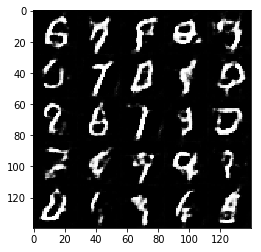

Epoch 1/2 - Batch 910/1875:  Discriminator loss = 0.6262  Generator loss = 1.7904
Epoch 1/2 - Batch 920/1875:  Discriminator loss = 0.8148  Generator loss = 1.2976
Epoch 1/2 - Batch 930/1875:  Discriminator loss = 0.8214  Generator loss = 1.2598
Epoch 1/2 - Batch 940/1875:  Discriminator loss = 1.2272  Generator loss = 0.6645
Epoch 1/2 - Batch 950/1875:  Discriminator loss = 0.7440  Generator loss = 1.8938
Epoch 1/2 - Batch 960/1875:  Discriminator loss = 0.7034  Generator loss = 1.9706
Epoch 1/2 - Batch 970/1875:  Discriminator loss = 0.8266  Generator loss = 1.1510
Epoch 1/2 - Batch 980/1875:  Discriminator loss = 0.6658  Generator loss = 1.5055
Epoch 1/2 - Batch 990/1875:  Discriminator loss = 0.6190  Generator loss = 1.5495
Epoch 1/2 - Batch 1000/1875:  Discriminator loss = 0.5822  Generator loss = 1.8993


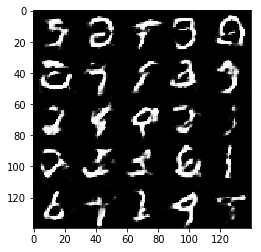

Epoch 1/2 - Batch 1010/1875:  Discriminator loss = 0.7069  Generator loss = 1.4142
Epoch 1/2 - Batch 1020/1875:  Discriminator loss = 1.5939  Generator loss = 0.4351
Epoch 1/2 - Batch 1030/1875:  Discriminator loss = 0.8258  Generator loss = 1.1108
Epoch 1/2 - Batch 1040/1875:  Discriminator loss = 0.5395  Generator loss = 2.1890
Epoch 1/2 - Batch 1050/1875:  Discriminator loss = 0.8404  Generator loss = 1.6434
Epoch 1/2 - Batch 1060/1875:  Discriminator loss = 0.9250  Generator loss = 2.4889
Epoch 1/2 - Batch 1070/1875:  Discriminator loss = 0.7727  Generator loss = 2.1918
Epoch 1/2 - Batch 1080/1875:  Discriminator loss = 1.0943  Generator loss = 0.7547
Epoch 1/2 - Batch 1090/1875:  Discriminator loss = 0.6807  Generator loss = 1.5021
Epoch 1/2 - Batch 1100/1875:  Discriminator loss = 0.6159  Generator loss = 1.6413


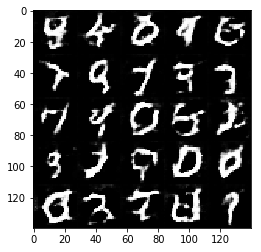

Epoch 1/2 - Batch 1110/1875:  Discriminator loss = 0.5860  Generator loss = 2.0896
Epoch 1/2 - Batch 1120/1875:  Discriminator loss = 0.7474  Generator loss = 1.3979
Epoch 1/2 - Batch 1130/1875:  Discriminator loss = 0.6290  Generator loss = 1.6075
Epoch 1/2 - Batch 1140/1875:  Discriminator loss = 0.7309  Generator loss = 1.2905
Epoch 1/2 - Batch 1150/1875:  Discriminator loss = 2.5094  Generator loss = 0.1848
Epoch 1/2 - Batch 1160/1875:  Discriminator loss = 0.7288  Generator loss = 1.5681
Epoch 1/2 - Batch 1170/1875:  Discriminator loss = 0.7798  Generator loss = 2.0383
Epoch 1/2 - Batch 1180/1875:  Discriminator loss = 1.0007  Generator loss = 1.0314
Epoch 1/2 - Batch 1190/1875:  Discriminator loss = 1.6081  Generator loss = 0.4531
Epoch 1/2 - Batch 1200/1875:  Discriminator loss = 0.8247  Generator loss = 1.2256


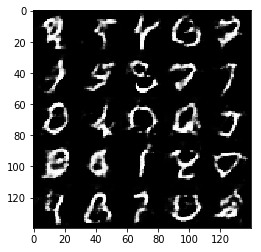

Epoch 1/2 - Batch 1210/1875:  Discriminator loss = 0.9127  Generator loss = 1.6879
Epoch 1/2 - Batch 1220/1875:  Discriminator loss = 1.7391  Generator loss = 0.3545
Epoch 1/2 - Batch 1230/1875:  Discriminator loss = 0.6833  Generator loss = 1.6202
Epoch 1/2 - Batch 1240/1875:  Discriminator loss = 1.0312  Generator loss = 0.8277
Epoch 1/2 - Batch 1250/1875:  Discriminator loss = 0.7394  Generator loss = 1.2262
Epoch 1/2 - Batch 1260/1875:  Discriminator loss = 0.5959  Generator loss = 1.8553
Epoch 1/2 - Batch 1270/1875:  Discriminator loss = 0.6380  Generator loss = 1.5748
Epoch 1/2 - Batch 1280/1875:  Discriminator loss = 0.7168  Generator loss = 1.3335
Epoch 1/2 - Batch 1290/1875:  Discriminator loss = 0.7815  Generator loss = 1.2137
Epoch 1/2 - Batch 1300/1875:  Discriminator loss = 0.6377  Generator loss = 1.5158


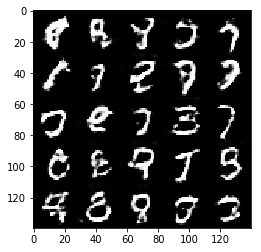

Epoch 1/2 - Batch 1310/1875:  Discriminator loss = 1.3222  Generator loss = 0.5970
Epoch 1/2 - Batch 1320/1875:  Discriminator loss = 0.7733  Generator loss = 1.2306
Epoch 1/2 - Batch 1330/1875:  Discriminator loss = 0.7278  Generator loss = 1.4298
Epoch 1/2 - Batch 1340/1875:  Discriminator loss = 2.5882  Generator loss = 4.0969
Epoch 1/2 - Batch 1350/1875:  Discriminator loss = 0.8260  Generator loss = 1.2056
Epoch 1/2 - Batch 1360/1875:  Discriminator loss = 0.9383  Generator loss = 1.1385
Epoch 1/2 - Batch 1370/1875:  Discriminator loss = 0.9224  Generator loss = 1.0839
Epoch 1/2 - Batch 1380/1875:  Discriminator loss = 1.2004  Generator loss = 0.6958
Epoch 1/2 - Batch 1390/1875:  Discriminator loss = 0.8645  Generator loss = 1.1021
Epoch 1/2 - Batch 1400/1875:  Discriminator loss = 1.0572  Generator loss = 0.7818


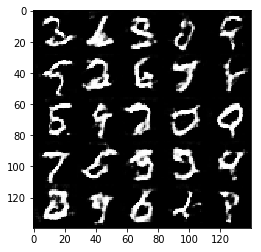

Epoch 1/2 - Batch 1410/1875:  Discriminator loss = 0.6403  Generator loss = 1.5586
Epoch 1/2 - Batch 1420/1875:  Discriminator loss = 1.3464  Generator loss = 0.5853
Epoch 1/2 - Batch 1430/1875:  Discriminator loss = 0.7958  Generator loss = 1.1873
Epoch 1/2 - Batch 1440/1875:  Discriminator loss = 0.6503  Generator loss = 1.5489
Epoch 1/2 - Batch 1450/1875:  Discriminator loss = 2.4212  Generator loss = 0.2619
Epoch 1/2 - Batch 1460/1875:  Discriminator loss = 0.6293  Generator loss = 2.4687
Epoch 1/2 - Batch 1470/1875:  Discriminator loss = 0.8876  Generator loss = 0.9884
Epoch 1/2 - Batch 1480/1875:  Discriminator loss = 0.9444  Generator loss = 1.0101
Epoch 1/2 - Batch 1490/1875:  Discriminator loss = 0.5824  Generator loss = 1.6643
Epoch 1/2 - Batch 1500/1875:  Discriminator loss = 0.7214  Generator loss = 1.3887


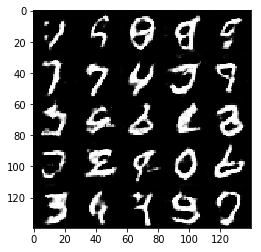

Epoch 1/2 - Batch 1510/1875:  Discriminator loss = 1.0312  Generator loss = 0.7956
Epoch 1/2 - Batch 1520/1875:  Discriminator loss = 0.8405  Generator loss = 1.4442
Epoch 1/2 - Batch 1530/1875:  Discriminator loss = 0.6213  Generator loss = 1.7494
Epoch 1/2 - Batch 1540/1875:  Discriminator loss = 0.9099  Generator loss = 1.0760
Epoch 1/2 - Batch 1550/1875:  Discriminator loss = 0.8704  Generator loss = 1.1344
Epoch 1/2 - Batch 1560/1875:  Discriminator loss = 0.6695  Generator loss = 1.5028
Epoch 1/2 - Batch 1570/1875:  Discriminator loss = 0.6974  Generator loss = 1.4667
Epoch 1/2 - Batch 1580/1875:  Discriminator loss = 0.6379  Generator loss = 1.5632
Epoch 1/2 - Batch 1590/1875:  Discriminator loss = 1.4084  Generator loss = 0.5285
Epoch 1/2 - Batch 1600/1875:  Discriminator loss = 0.8207  Generator loss = 1.1111


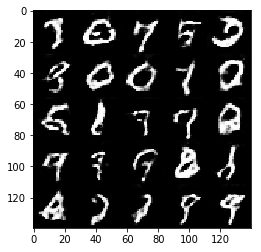

Epoch 1/2 - Batch 1610/1875:  Discriminator loss = 0.8250  Generator loss = 1.1025
Epoch 1/2 - Batch 1620/1875:  Discriminator loss = 0.6681  Generator loss = 1.3934
Epoch 1/2 - Batch 1630/1875:  Discriminator loss = 0.7150  Generator loss = 1.3547
Epoch 1/2 - Batch 1640/1875:  Discriminator loss = 1.9654  Generator loss = 3.7696
Epoch 1/2 - Batch 1650/1875:  Discriminator loss = 0.9949  Generator loss = 0.9554
Epoch 1/2 - Batch 1660/1875:  Discriminator loss = 0.9443  Generator loss = 0.9589
Epoch 1/2 - Batch 1670/1875:  Discriminator loss = 0.9139  Generator loss = 1.3275
Epoch 1/2 - Batch 1680/1875:  Discriminator loss = 1.1031  Generator loss = 0.7915
Epoch 1/2 - Batch 1690/1875:  Discriminator loss = 0.7585  Generator loss = 2.1530
Epoch 1/2 - Batch 1700/1875:  Discriminator loss = 0.7380  Generator loss = 1.5735


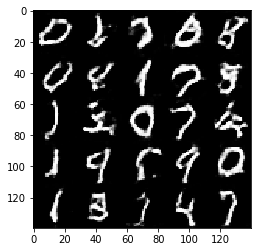

Epoch 1/2 - Batch 1710/1875:  Discriminator loss = 0.8196  Generator loss = 1.2119
Epoch 1/2 - Batch 1720/1875:  Discriminator loss = 0.7568  Generator loss = 1.4735
Epoch 1/2 - Batch 1730/1875:  Discriminator loss = 0.8197  Generator loss = 1.1669
Epoch 1/2 - Batch 1740/1875:  Discriminator loss = 0.8118  Generator loss = 1.3583
Epoch 1/2 - Batch 1750/1875:  Discriminator loss = 0.8164  Generator loss = 1.1502
Epoch 1/2 - Batch 1760/1875:  Discriminator loss = 0.8088  Generator loss = 1.0912
Epoch 1/2 - Batch 1770/1875:  Discriminator loss = 0.8739  Generator loss = 1.9642
Epoch 1/2 - Batch 1780/1875:  Discriminator loss = 0.7084  Generator loss = 1.5088
Epoch 1/2 - Batch 1790/1875:  Discriminator loss = 1.0242  Generator loss = 0.8774
Epoch 1/2 - Batch 1800/1875:  Discriminator loss = 0.5881  Generator loss = 2.3402


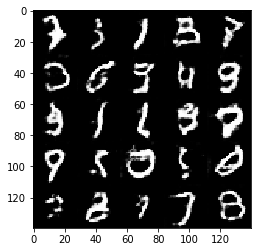

Epoch 1/2 - Batch 1810/1875:  Discriminator loss = 0.8389  Generator loss = 1.0633
Epoch 1/2 - Batch 1820/1875:  Discriminator loss = 0.6520  Generator loss = 1.7984
Epoch 1/2 - Batch 1830/1875:  Discriminator loss = 0.8745  Generator loss = 1.0757
Epoch 1/2 - Batch 1840/1875:  Discriminator loss = 0.7074  Generator loss = 2.1702
Epoch 1/2 - Batch 1850/1875:  Discriminator loss = 1.0183  Generator loss = 0.9762
Epoch 1/2 - Batch 1860/1875:  Discriminator loss = 0.7475  Generator loss = 1.5501
Epoch 1/2 - Batch 1870/1875:  Discriminator loss = 0.7853  Generator loss = 1.2823
Epoch 2/2 - Batch 10/1875:  Discriminator loss = 0.8869  Generator loss = 1.2784
Epoch 2/2 - Batch 20/1875:  Discriminator loss = 1.1407  Generator loss = 2.7586
Epoch 2/2 - Batch 30/1875:  Discriminator loss = 0.8648  Generator loss = 1.0508
Epoch 2/2 - Batch 40/1875:  Discriminator loss = 0.8737  Generator loss = 1.1405
Epoch 2/2 - Batch 50/1875:  Discriminator loss = 0.7164  Generator loss = 1.5858
Epoch 2/2 - Ba

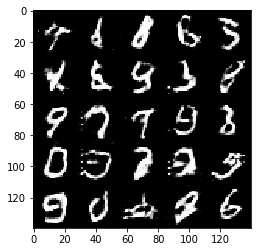

Epoch 2/2 - Batch 110/1875:  Discriminator loss = 0.9793  Generator loss = 2.1655
Epoch 2/2 - Batch 120/1875:  Discriminator loss = 0.8679  Generator loss = 1.2218
Epoch 2/2 - Batch 130/1875:  Discriminator loss = 0.7054  Generator loss = 1.3974
Epoch 2/2 - Batch 140/1875:  Discriminator loss = 0.8850  Generator loss = 0.9817
Epoch 2/2 - Batch 150/1875:  Discriminator loss = 0.7734  Generator loss = 1.2638
Epoch 2/2 - Batch 160/1875:  Discriminator loss = 0.6147  Generator loss = 1.8279
Epoch 2/2 - Batch 170/1875:  Discriminator loss = 1.1008  Generator loss = 0.7941
Epoch 2/2 - Batch 180/1875:  Discriminator loss = 1.4100  Generator loss = 0.5314
Epoch 2/2 - Batch 190/1875:  Discriminator loss = 0.5908  Generator loss = 1.7218
Epoch 2/2 - Batch 200/1875:  Discriminator loss = 0.7085  Generator loss = 1.3095


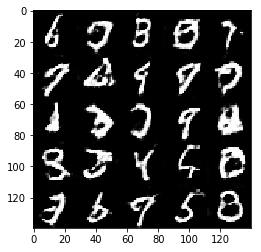

Epoch 2/2 - Batch 210/1875:  Discriminator loss = 0.7478  Generator loss = 1.5133
Epoch 2/2 - Batch 220/1875:  Discriminator loss = 1.1869  Generator loss = 0.8672
Epoch 2/2 - Batch 230/1875:  Discriminator loss = 0.6956  Generator loss = 1.8055
Epoch 2/2 - Batch 240/1875:  Discriminator loss = 0.6299  Generator loss = 1.7945
Epoch 2/2 - Batch 250/1875:  Discriminator loss = 0.9094  Generator loss = 0.9366
Epoch 2/2 - Batch 260/1875:  Discriminator loss = 0.9056  Generator loss = 0.9871
Epoch 2/2 - Batch 270/1875:  Discriminator loss = 0.7024  Generator loss = 1.4407
Epoch 2/2 - Batch 280/1875:  Discriminator loss = 0.9994  Generator loss = 0.9356
Epoch 2/2 - Batch 290/1875:  Discriminator loss = 0.7702  Generator loss = 1.1804
Epoch 2/2 - Batch 300/1875:  Discriminator loss = 0.6857  Generator loss = 1.4089


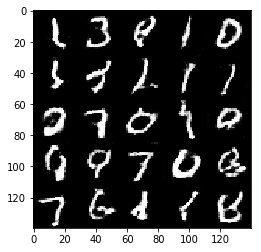

Epoch 2/2 - Batch 310/1875:  Discriminator loss = 0.5928  Generator loss = 1.8606
Epoch 2/2 - Batch 320/1875:  Discriminator loss = 0.6110  Generator loss = 1.7167
Epoch 2/2 - Batch 330/1875:  Discriminator loss = 0.5978  Generator loss = 1.7546
Epoch 2/2 - Batch 340/1875:  Discriminator loss = 1.3709  Generator loss = 0.5951
Epoch 2/2 - Batch 350/1875:  Discriminator loss = 0.8149  Generator loss = 1.1746
Epoch 2/2 - Batch 360/1875:  Discriminator loss = 1.5958  Generator loss = 0.5020
Epoch 2/2 - Batch 370/1875:  Discriminator loss = 0.6341  Generator loss = 1.8729
Epoch 2/2 - Batch 380/1875:  Discriminator loss = 0.7775  Generator loss = 2.3281
Epoch 2/2 - Batch 390/1875:  Discriminator loss = 1.0844  Generator loss = 0.7635
Epoch 2/2 - Batch 400/1875:  Discriminator loss = 1.7417  Generator loss = 0.4079


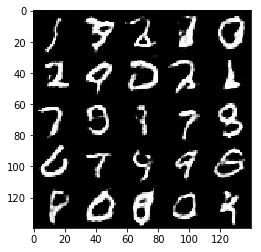

Epoch 2/2 - Batch 410/1875:  Discriminator loss = 0.6122  Generator loss = 1.9308
Epoch 2/2 - Batch 420/1875:  Discriminator loss = 0.6169  Generator loss = 2.1629
Epoch 2/2 - Batch 430/1875:  Discriminator loss = 0.6153  Generator loss = 1.5762
Epoch 2/2 - Batch 440/1875:  Discriminator loss = 1.5272  Generator loss = 0.4737
Epoch 2/2 - Batch 450/1875:  Discriminator loss = 0.7867  Generator loss = 1.2022
Epoch 2/2 - Batch 460/1875:  Discriminator loss = 0.6590  Generator loss = 1.6980
Epoch 2/2 - Batch 470/1875:  Discriminator loss = 1.1938  Generator loss = 0.8532
Epoch 2/2 - Batch 480/1875:  Discriminator loss = 0.9162  Generator loss = 1.0265
Epoch 2/2 - Batch 490/1875:  Discriminator loss = 0.7008  Generator loss = 1.4069
Epoch 2/2 - Batch 500/1875:  Discriminator loss = 0.4783  Generator loss = 2.9814


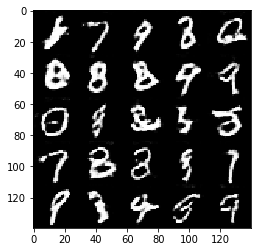

Epoch 2/2 - Batch 510/1875:  Discriminator loss = 0.7848  Generator loss = 1.1997
Epoch 2/2 - Batch 520/1875:  Discriminator loss = 0.5323  Generator loss = 1.9980
Epoch 2/2 - Batch 530/1875:  Discriminator loss = 0.9220  Generator loss = 1.0068
Epoch 2/2 - Batch 540/1875:  Discriminator loss = 1.0399  Generator loss = 0.8912
Epoch 2/2 - Batch 550/1875:  Discriminator loss = 0.6571  Generator loss = 1.6870
Epoch 2/2 - Batch 560/1875:  Discriminator loss = 0.7211  Generator loss = 1.7921
Epoch 2/2 - Batch 570/1875:  Discriminator loss = 0.4901  Generator loss = 2.2948
Epoch 2/2 - Batch 580/1875:  Discriminator loss = 0.6623  Generator loss = 1.5235
Epoch 2/2 - Batch 590/1875:  Discriminator loss = 0.7654  Generator loss = 1.7988
Epoch 2/2 - Batch 600/1875:  Discriminator loss = 0.7328  Generator loss = 1.8035


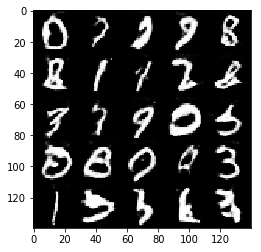

Epoch 2/2 - Batch 610/1875:  Discriminator loss = 1.0158  Generator loss = 1.9683
Epoch 2/2 - Batch 620/1875:  Discriminator loss = 0.6680  Generator loss = 1.9942
Epoch 2/2 - Batch 630/1875:  Discriminator loss = 0.5479  Generator loss = 2.1380
Epoch 2/2 - Batch 640/1875:  Discriminator loss = 0.8078  Generator loss = 1.3280
Epoch 2/2 - Batch 650/1875:  Discriminator loss = 0.5859  Generator loss = 1.8594
Epoch 2/2 - Batch 660/1875:  Discriminator loss = 1.2624  Generator loss = 0.6212
Epoch 2/2 - Batch 670/1875:  Discriminator loss = 0.6202  Generator loss = 1.6792
Epoch 2/2 - Batch 680/1875:  Discriminator loss = 0.8600  Generator loss = 1.1423
Epoch 2/2 - Batch 690/1875:  Discriminator loss = 0.7662  Generator loss = 2.2077
Epoch 2/2 - Batch 700/1875:  Discriminator loss = 0.5381  Generator loss = 2.0230


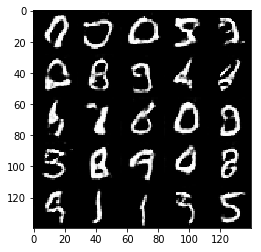

Epoch 2/2 - Batch 710/1875:  Discriminator loss = 0.8889  Generator loss = 1.0442
Epoch 2/2 - Batch 720/1875:  Discriminator loss = 1.8225  Generator loss = 0.3716
Epoch 2/2 - Batch 730/1875:  Discriminator loss = 0.9607  Generator loss = 1.0784
Epoch 2/2 - Batch 740/1875:  Discriminator loss = 0.8990  Generator loss = 1.0541
Epoch 2/2 - Batch 750/1875:  Discriminator loss = 0.8972  Generator loss = 0.9494
Epoch 2/2 - Batch 760/1875:  Discriminator loss = 0.6083  Generator loss = 1.6781
Epoch 2/2 - Batch 770/1875:  Discriminator loss = 0.6333  Generator loss = 2.0065
Epoch 2/2 - Batch 780/1875:  Discriminator loss = 2.9037  Generator loss = 5.1651
Epoch 2/2 - Batch 790/1875:  Discriminator loss = 0.6923  Generator loss = 1.7764
Epoch 2/2 - Batch 800/1875:  Discriminator loss = 0.8669  Generator loss = 1.0501


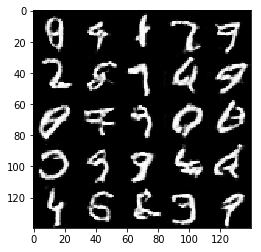

Epoch 2/2 - Batch 810/1875:  Discriminator loss = 0.7485  Generator loss = 1.5081
Epoch 2/2 - Batch 820/1875:  Discriminator loss = 0.6333  Generator loss = 1.8707
Epoch 2/2 - Batch 830/1875:  Discriminator loss = 0.7821  Generator loss = 1.2985
Epoch 2/2 - Batch 840/1875:  Discriminator loss = 0.5873  Generator loss = 2.2132
Epoch 2/2 - Batch 850/1875:  Discriminator loss = 0.5977  Generator loss = 2.4865
Epoch 2/2 - Batch 860/1875:  Discriminator loss = 0.9560  Generator loss = 1.0244
Epoch 2/2 - Batch 870/1875:  Discriminator loss = 0.5970  Generator loss = 1.8869
Epoch 2/2 - Batch 880/1875:  Discriminator loss = 1.3225  Generator loss = 0.7543
Epoch 2/2 - Batch 890/1875:  Discriminator loss = 0.5385  Generator loss = 2.0877
Epoch 2/2 - Batch 900/1875:  Discriminator loss = 1.2917  Generator loss = 0.6328


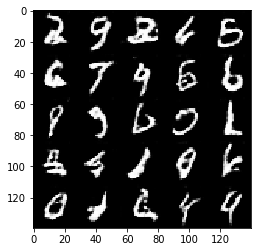

Epoch 2/2 - Batch 910/1875:  Discriminator loss = 0.6843  Generator loss = 2.9607
Epoch 2/2 - Batch 920/1875:  Discriminator loss = 0.5797  Generator loss = 1.8857
Epoch 2/2 - Batch 930/1875:  Discriminator loss = 0.5915  Generator loss = 1.9243
Epoch 2/2 - Batch 940/1875:  Discriminator loss = 0.6052  Generator loss = 1.8543
Epoch 2/2 - Batch 950/1875:  Discriminator loss = 0.6649  Generator loss = 1.5284
Epoch 2/2 - Batch 960/1875:  Discriminator loss = 0.6335  Generator loss = 2.4001
Epoch 2/2 - Batch 970/1875:  Discriminator loss = 0.8081  Generator loss = 1.1891
Epoch 2/2 - Batch 980/1875:  Discriminator loss = 0.5288  Generator loss = 2.4276
Epoch 2/2 - Batch 990/1875:  Discriminator loss = 0.5201  Generator loss = 2.0783
Epoch 2/2 - Batch 1000/1875:  Discriminator loss = 0.4710  Generator loss = 2.6617


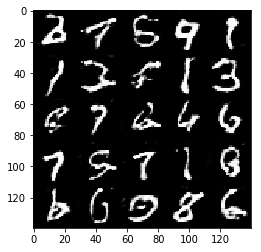

Epoch 2/2 - Batch 1010/1875:  Discriminator loss = 0.5971  Generator loss = 1.7668
Epoch 2/2 - Batch 1020/1875:  Discriminator loss = 0.6409  Generator loss = 1.5987
Epoch 2/2 - Batch 1030/1875:  Discriminator loss = 0.7991  Generator loss = 1.6684
Epoch 2/2 - Batch 1040/1875:  Discriminator loss = 0.7916  Generator loss = 1.3965
Epoch 2/2 - Batch 1050/1875:  Discriminator loss = 0.7707  Generator loss = 1.5670
Epoch 2/2 - Batch 1060/1875:  Discriminator loss = 0.7341  Generator loss = 3.5070
Epoch 2/2 - Batch 1070/1875:  Discriminator loss = 0.5460  Generator loss = 2.3486
Epoch 2/2 - Batch 1080/1875:  Discriminator loss = 0.6724  Generator loss = 1.5945
Epoch 2/2 - Batch 1090/1875:  Discriminator loss = 0.7344  Generator loss = 1.3504
Epoch 2/2 - Batch 1100/1875:  Discriminator loss = 1.9120  Generator loss = 0.4816


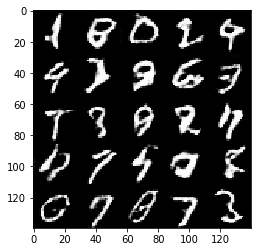

Epoch 2/2 - Batch 1110/1875:  Discriminator loss = 0.6150  Generator loss = 2.2807
Epoch 2/2 - Batch 1120/1875:  Discriminator loss = 0.6872  Generator loss = 1.4233
Epoch 2/2 - Batch 1130/1875:  Discriminator loss = 0.6850  Generator loss = 2.4971
Epoch 2/2 - Batch 1140/1875:  Discriminator loss = 0.9130  Generator loss = 0.9792
Epoch 2/2 - Batch 1150/1875:  Discriminator loss = 0.7045  Generator loss = 1.4460
Epoch 2/2 - Batch 1160/1875:  Discriminator loss = 0.4946  Generator loss = 2.8675
Epoch 2/2 - Batch 1170/1875:  Discriminator loss = 0.6363  Generator loss = 1.6348
Epoch 2/2 - Batch 1180/1875:  Discriminator loss = 0.7371  Generator loss = 1.8677
Epoch 2/2 - Batch 1190/1875:  Discriminator loss = 0.8707  Generator loss = 1.1187
Epoch 2/2 - Batch 1200/1875:  Discriminator loss = 0.5780  Generator loss = 2.0097


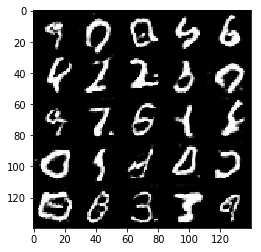

Epoch 2/2 - Batch 1210/1875:  Discriminator loss = 0.6518  Generator loss = 2.6090
Epoch 2/2 - Batch 1220/1875:  Discriminator loss = 0.6086  Generator loss = 1.7212
Epoch 2/2 - Batch 1230/1875:  Discriminator loss = 0.8564  Generator loss = 1.1156
Epoch 2/2 - Batch 1240/1875:  Discriminator loss = 0.6662  Generator loss = 1.5802
Epoch 2/2 - Batch 1250/1875:  Discriminator loss = 0.6584  Generator loss = 1.6089
Epoch 2/2 - Batch 1260/1875:  Discriminator loss = 0.8420  Generator loss = 1.2474
Epoch 2/2 - Batch 1270/1875:  Discriminator loss = 0.4806  Generator loss = 2.4868
Epoch 2/2 - Batch 1280/1875:  Discriminator loss = 0.7004  Generator loss = 1.4335
Epoch 2/2 - Batch 1290/1875:  Discriminator loss = 0.7828  Generator loss = 1.2655
Epoch 2/2 - Batch 1300/1875:  Discriminator loss = 0.5046  Generator loss = 2.0890


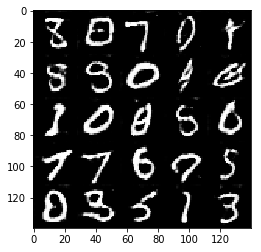

Epoch 2/2 - Batch 1310/1875:  Discriminator loss = 0.9125  Generator loss = 1.1205
Epoch 2/2 - Batch 1320/1875:  Discriminator loss = 0.6941  Generator loss = 1.5072
Epoch 2/2 - Batch 1330/1875:  Discriminator loss = 0.5096  Generator loss = 2.7313
Epoch 2/2 - Batch 1340/1875:  Discriminator loss = 0.6873  Generator loss = 1.4476
Epoch 2/2 - Batch 1350/1875:  Discriminator loss = 0.6318  Generator loss = 1.6995
Epoch 2/2 - Batch 1360/1875:  Discriminator loss = 0.9394  Generator loss = 1.1365
Epoch 2/2 - Batch 1370/1875:  Discriminator loss = 1.1147  Generator loss = 0.8428
Epoch 2/2 - Batch 1380/1875:  Discriminator loss = 1.1626  Generator loss = 0.7981
Epoch 2/2 - Batch 1390/1875:  Discriminator loss = 0.6590  Generator loss = 1.6637
Epoch 2/2 - Batch 1400/1875:  Discriminator loss = 1.1145  Generator loss = 0.7473


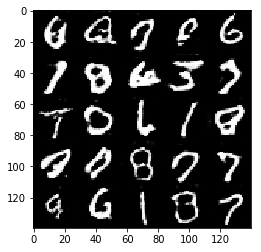

Epoch 2/2 - Batch 1410/1875:  Discriminator loss = 0.6055  Generator loss = 1.7565
Epoch 2/2 - Batch 1420/1875:  Discriminator loss = 1.0395  Generator loss = 0.8825
Epoch 2/2 - Batch 1430/1875:  Discriminator loss = 0.7958  Generator loss = 1.2413
Epoch 2/2 - Batch 1440/1875:  Discriminator loss = 0.6558  Generator loss = 1.5393
Epoch 2/2 - Batch 1450/1875:  Discriminator loss = 0.5651  Generator loss = 2.2287
Epoch 2/2 - Batch 1460/1875:  Discriminator loss = 0.6356  Generator loss = 1.6015
Epoch 2/2 - Batch 1470/1875:  Discriminator loss = 0.6597  Generator loss = 2.5655
Epoch 2/2 - Batch 1480/1875:  Discriminator loss = 0.8262  Generator loss = 2.0924
Epoch 2/2 - Batch 1490/1875:  Discriminator loss = 1.1031  Generator loss = 3.6223
Epoch 2/2 - Batch 1500/1875:  Discriminator loss = 0.6330  Generator loss = 1.8192


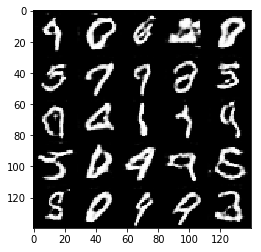

Epoch 2/2 - Batch 1510/1875:  Discriminator loss = 0.7299  Generator loss = 2.8635
Epoch 2/2 - Batch 1520/1875:  Discriminator loss = 0.7043  Generator loss = 1.4830
Epoch 2/2 - Batch 1530/1875:  Discriminator loss = 0.6816  Generator loss = 1.4994
Epoch 2/2 - Batch 1540/1875:  Discriminator loss = 0.9009  Generator loss = 1.2903
Epoch 2/2 - Batch 1550/1875:  Discriminator loss = 0.7753  Generator loss = 1.2601
Epoch 2/2 - Batch 1560/1875:  Discriminator loss = 0.5129  Generator loss = 2.2418
Epoch 2/2 - Batch 1570/1875:  Discriminator loss = 0.5371  Generator loss = 2.2457
Epoch 2/2 - Batch 1580/1875:  Discriminator loss = 0.5872  Generator loss = 1.8132
Epoch 2/2 - Batch 1590/1875:  Discriminator loss = 0.9098  Generator loss = 1.0212
Epoch 2/2 - Batch 1600/1875:  Discriminator loss = 0.9787  Generator loss = 1.0671


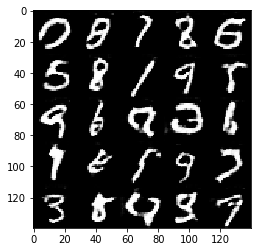

Epoch 2/2 - Batch 1610/1875:  Discriminator loss = 0.7157  Generator loss = 1.3857
Epoch 2/2 - Batch 1620/1875:  Discriminator loss = 0.6060  Generator loss = 2.4132
Epoch 2/2 - Batch 1630/1875:  Discriminator loss = 1.4915  Generator loss = 0.6430
Epoch 2/2 - Batch 1640/1875:  Discriminator loss = 0.5991  Generator loss = 1.9258
Epoch 2/2 - Batch 1650/1875:  Discriminator loss = 0.7367  Generator loss = 1.3673
Epoch 2/2 - Batch 1660/1875:  Discriminator loss = 0.6271  Generator loss = 1.5319
Epoch 2/2 - Batch 1670/1875:  Discriminator loss = 0.8062  Generator loss = 1.2596
Epoch 2/2 - Batch 1680/1875:  Discriminator loss = 0.7319  Generator loss = 1.3366
Epoch 2/2 - Batch 1690/1875:  Discriminator loss = 0.6135  Generator loss = 1.7338
Epoch 2/2 - Batch 1700/1875:  Discriminator loss = 1.2074  Generator loss = 0.8839


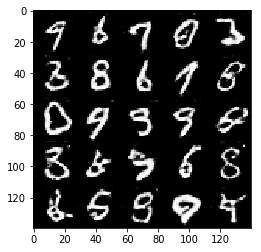

Epoch 2/2 - Batch 1710/1875:  Discriminator loss = 0.5892  Generator loss = 1.9649
Epoch 2/2 - Batch 1720/1875:  Discriminator loss = 0.5754  Generator loss = 2.9384
Epoch 2/2 - Batch 1730/1875:  Discriminator loss = 0.5946  Generator loss = 2.5145
Epoch 2/2 - Batch 1740/1875:  Discriminator loss = 0.6115  Generator loss = 1.7259
Epoch 2/2 - Batch 1750/1875:  Discriminator loss = 0.7283  Generator loss = 1.4257
Epoch 2/2 - Batch 1760/1875:  Discriminator loss = 0.5050  Generator loss = 2.1895
Epoch 2/2 - Batch 1770/1875:  Discriminator loss = 0.6293  Generator loss = 1.5926
Epoch 2/2 - Batch 1780/1875:  Discriminator loss = 0.7024  Generator loss = 1.4292
Epoch 2/2 - Batch 1790/1875:  Discriminator loss = 0.6783  Generator loss = 1.4308
Epoch 2/2 - Batch 1800/1875:  Discriminator loss = 0.4824  Generator loss = 2.3832


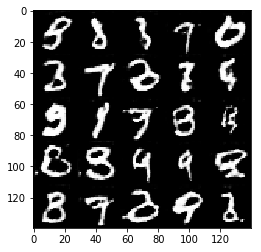

Epoch 2/2 - Batch 1810/1875:  Discriminator loss = 0.8039  Generator loss = 1.1250
Epoch 2/2 - Batch 1820/1875:  Discriminator loss = 0.6574  Generator loss = 1.7625
Epoch 2/2 - Batch 1830/1875:  Discriminator loss = 0.7392  Generator loss = 1.3482
Epoch 2/2 - Batch 1840/1875:  Discriminator loss = 0.4304  Generator loss = 3.6702
Epoch 2/2 - Batch 1850/1875:  Discriminator loss = 0.7971  Generator loss = 1.4373
Epoch 2/2 - Batch 1860/1875:  Discriminator loss = 0.9353  Generator loss = 2.9833
Epoch 2/2 - Batch 1870/1875:  Discriminator loss = 0.6672  Generator loss = 2.2509


In [17]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/6331:  Discriminator loss = 0.9850  Generator loss = 0.9635
Epoch 1/1 - Batch 20/6331:  Discriminator loss = 0.7207  Generator loss = 1.4229
Epoch 1/1 - Batch 30/6331:  Discriminator loss = 0.6427  Generator loss = 3.4594
Epoch 1/1 - Batch 40/6331:  Discriminator loss = 0.5289  Generator loss = 2.1758
Epoch 1/1 - Batch 50/6331:  Discriminator loss = 0.6418  Generator loss = 1.6536
Epoch 1/1 - Batch 60/6331:  Discriminator loss = 0.5916  Generator loss = 5.9580
Epoch 1/1 - Batch 70/6331:  Discriminator loss = 0.4350  Generator loss = 4.1445
Epoch 1/1 - Batch 80/6331:  Discriminator loss = 0.8186  Generator loss = 5.0114
Epoch 1/1 - Batch 90/6331:  Discriminator loss = 0.7715  Generator loss = 1.6695
Epoch 1/1 - Batch 100/6331:  Discriminator loss = 0.7405  Generator loss = 1.8676


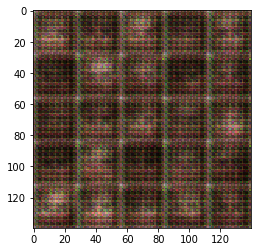

Epoch 1/1 - Batch 110/6331:  Discriminator loss = 0.8873  Generator loss = 2.9724
Epoch 1/1 - Batch 120/6331:  Discriminator loss = 0.6917  Generator loss = 1.9341
Epoch 1/1 - Batch 130/6331:  Discriminator loss = 1.3498  Generator loss = 5.9224
Epoch 1/1 - Batch 140/6331:  Discriminator loss = 0.6008  Generator loss = 2.4444
Epoch 1/1 - Batch 150/6331:  Discriminator loss = 0.5106  Generator loss = 2.9506
Epoch 1/1 - Batch 160/6331:  Discriminator loss = 1.7579  Generator loss = 6.5018
Epoch 1/1 - Batch 170/6331:  Discriminator loss = 0.6762  Generator loss = 1.8534
Epoch 1/1 - Batch 180/6331:  Discriminator loss = 0.6658  Generator loss = 2.3894
Epoch 1/1 - Batch 190/6331:  Discriminator loss = 0.8044  Generator loss = 1.3695
Epoch 1/1 - Batch 200/6331:  Discriminator loss = 0.5967  Generator loss = 2.4042


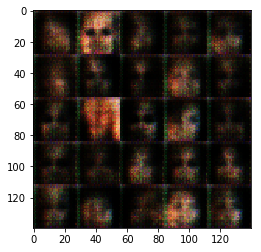

Epoch 1/1 - Batch 210/6331:  Discriminator loss = 1.2349  Generator loss = 0.7944
Epoch 1/1 - Batch 220/6331:  Discriminator loss = 0.6474  Generator loss = 2.4562
Epoch 1/1 - Batch 230/6331:  Discriminator loss = 0.5487  Generator loss = 2.8808
Epoch 1/1 - Batch 240/6331:  Discriminator loss = 0.5905  Generator loss = 1.9590
Epoch 1/1 - Batch 250/6331:  Discriminator loss = 0.6629  Generator loss = 1.8383
Epoch 1/1 - Batch 260/6331:  Discriminator loss = 0.6082  Generator loss = 3.0068
Epoch 1/1 - Batch 270/6331:  Discriminator loss = 0.8429  Generator loss = 1.2552
Epoch 1/1 - Batch 280/6331:  Discriminator loss = 0.7469  Generator loss = 2.2078
Epoch 1/1 - Batch 290/6331:  Discriminator loss = 0.5443  Generator loss = 2.7064
Epoch 1/1 - Batch 300/6331:  Discriminator loss = 1.1018  Generator loss = 2.1911


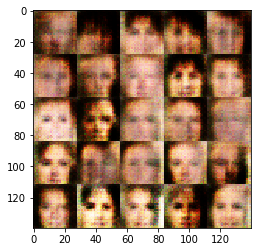

Epoch 1/1 - Batch 310/6331:  Discriminator loss = 0.8620  Generator loss = 2.1542
Epoch 1/1 - Batch 320/6331:  Discriminator loss = 1.0786  Generator loss = 1.1050
Epoch 1/1 - Batch 330/6331:  Discriminator loss = 1.5478  Generator loss = 0.4590
Epoch 1/1 - Batch 340/6331:  Discriminator loss = 1.5170  Generator loss = 3.9501
Epoch 1/1 - Batch 350/6331:  Discriminator loss = 1.1657  Generator loss = 0.7761
Epoch 1/1 - Batch 360/6331:  Discriminator loss = 1.4992  Generator loss = 0.5285
Epoch 1/1 - Batch 370/6331:  Discriminator loss = 1.4364  Generator loss = 0.5779
Epoch 1/1 - Batch 380/6331:  Discriminator loss = 0.8774  Generator loss = 1.2316
Epoch 1/1 - Batch 390/6331:  Discriminator loss = 0.7047  Generator loss = 2.1830
Epoch 1/1 - Batch 400/6331:  Discriminator loss = 0.8061  Generator loss = 1.5954


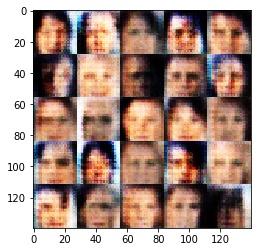

Epoch 1/1 - Batch 410/6331:  Discriminator loss = 0.8861  Generator loss = 1.6506
Epoch 1/1 - Batch 420/6331:  Discriminator loss = 0.8894  Generator loss = 1.5684
Epoch 1/1 - Batch 430/6331:  Discriminator loss = 1.1423  Generator loss = 0.8782
Epoch 1/1 - Batch 440/6331:  Discriminator loss = 0.9946  Generator loss = 1.4425
Epoch 1/1 - Batch 450/6331:  Discriminator loss = 0.8599  Generator loss = 1.4382
Epoch 1/1 - Batch 460/6331:  Discriminator loss = 1.7624  Generator loss = 3.6672
Epoch 1/1 - Batch 470/6331:  Discriminator loss = 0.9283  Generator loss = 1.5586
Epoch 1/1 - Batch 480/6331:  Discriminator loss = 1.0417  Generator loss = 1.1758
Epoch 1/1 - Batch 490/6331:  Discriminator loss = 1.2682  Generator loss = 0.8519
Epoch 1/1 - Batch 500/6331:  Discriminator loss = 1.0905  Generator loss = 0.8298


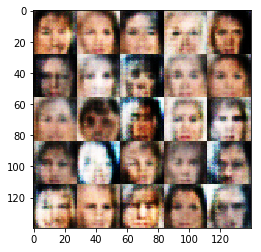

Epoch 1/1 - Batch 510/6331:  Discriminator loss = 1.0117  Generator loss = 1.3872
Epoch 1/1 - Batch 520/6331:  Discriminator loss = 1.3613  Generator loss = 0.6566
Epoch 1/1 - Batch 530/6331:  Discriminator loss = 0.8600  Generator loss = 1.5613
Epoch 1/1 - Batch 540/6331:  Discriminator loss = 1.2177  Generator loss = 2.8359
Epoch 1/1 - Batch 550/6331:  Discriminator loss = 0.8835  Generator loss = 1.2350
Epoch 1/1 - Batch 560/6331:  Discriminator loss = 1.2333  Generator loss = 0.6990
Epoch 1/1 - Batch 570/6331:  Discriminator loss = 1.1149  Generator loss = 1.5902
Epoch 1/1 - Batch 580/6331:  Discriminator loss = 0.8887  Generator loss = 1.3461
Epoch 1/1 - Batch 590/6331:  Discriminator loss = 1.1043  Generator loss = 0.8515
Epoch 1/1 - Batch 600/6331:  Discriminator loss = 1.3011  Generator loss = 0.6085


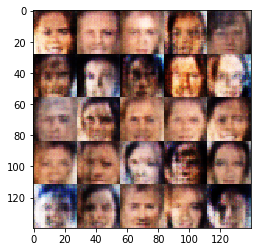

Epoch 1/1 - Batch 610/6331:  Discriminator loss = 1.1684  Generator loss = 1.9465
Epoch 1/1 - Batch 620/6331:  Discriminator loss = 1.1169  Generator loss = 1.1774
Epoch 1/1 - Batch 630/6331:  Discriminator loss = 1.1518  Generator loss = 0.8567
Epoch 1/1 - Batch 640/6331:  Discriminator loss = 1.4503  Generator loss = 0.5194
Epoch 1/1 - Batch 650/6331:  Discriminator loss = 0.9227  Generator loss = 1.1571
Epoch 1/1 - Batch 660/6331:  Discriminator loss = 1.1726  Generator loss = 0.7275
Epoch 1/1 - Batch 670/6331:  Discriminator loss = 1.0910  Generator loss = 1.4415
Epoch 1/1 - Batch 680/6331:  Discriminator loss = 0.8875  Generator loss = 1.3102
Epoch 1/1 - Batch 690/6331:  Discriminator loss = 0.8506  Generator loss = 1.4586
Epoch 1/1 - Batch 700/6331:  Discriminator loss = 0.8773  Generator loss = 1.3893


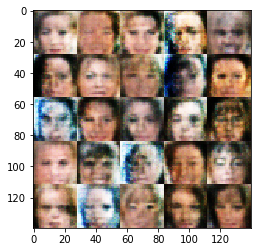

Epoch 1/1 - Batch 710/6331:  Discriminator loss = 0.9245  Generator loss = 1.3682
Epoch 1/1 - Batch 720/6331:  Discriminator loss = 1.0476  Generator loss = 1.4937
Epoch 1/1 - Batch 730/6331:  Discriminator loss = 0.9440  Generator loss = 1.4997
Epoch 1/1 - Batch 740/6331:  Discriminator loss = 1.1820  Generator loss = 1.1314
Epoch 1/1 - Batch 750/6331:  Discriminator loss = 0.9236  Generator loss = 2.2639
Epoch 1/1 - Batch 760/6331:  Discriminator loss = 1.0456  Generator loss = 1.1814
Epoch 1/1 - Batch 770/6331:  Discriminator loss = 1.2127  Generator loss = 0.7772
Epoch 1/1 - Batch 780/6331:  Discriminator loss = 1.0118  Generator loss = 1.1012
Epoch 1/1 - Batch 790/6331:  Discriminator loss = 1.1128  Generator loss = 0.8004
Epoch 1/1 - Batch 800/6331:  Discriminator loss = 1.4297  Generator loss = 0.6067


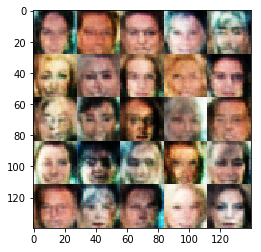

Epoch 1/1 - Batch 810/6331:  Discriminator loss = 1.2346  Generator loss = 0.6952
Epoch 1/1 - Batch 820/6331:  Discriminator loss = 1.1546  Generator loss = 0.7518
Epoch 1/1 - Batch 830/6331:  Discriminator loss = 1.2291  Generator loss = 0.6531
Epoch 1/1 - Batch 840/6331:  Discriminator loss = 1.4077  Generator loss = 0.5229
Epoch 1/1 - Batch 850/6331:  Discriminator loss = 1.1085  Generator loss = 0.8132
Epoch 1/1 - Batch 860/6331:  Discriminator loss = 1.1199  Generator loss = 1.3876
Epoch 1/1 - Batch 870/6331:  Discriminator loss = 1.2100  Generator loss = 0.7024
Epoch 1/1 - Batch 880/6331:  Discriminator loss = 1.0753  Generator loss = 1.1557
Epoch 1/1 - Batch 890/6331:  Discriminator loss = 1.2283  Generator loss = 1.6476
Epoch 1/1 - Batch 900/6331:  Discriminator loss = 0.9338  Generator loss = 1.1021


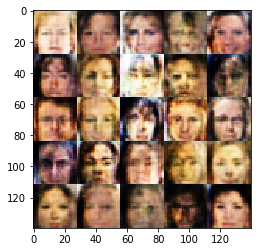

Epoch 1/1 - Batch 910/6331:  Discriminator loss = 1.1554  Generator loss = 1.0279
Epoch 1/1 - Batch 920/6331:  Discriminator loss = 1.0694  Generator loss = 0.9543
Epoch 1/1 - Batch 930/6331:  Discriminator loss = 1.0422  Generator loss = 0.9821
Epoch 1/1 - Batch 940/6331:  Discriminator loss = 1.0090  Generator loss = 1.2778
Epoch 1/1 - Batch 950/6331:  Discriminator loss = 0.9929  Generator loss = 0.9334
Epoch 1/1 - Batch 960/6331:  Discriminator loss = 1.0372  Generator loss = 1.1044
Epoch 1/1 - Batch 970/6331:  Discriminator loss = 0.9789  Generator loss = 1.7871
Epoch 1/1 - Batch 980/6331:  Discriminator loss = 0.9341  Generator loss = 1.0812
Epoch 1/1 - Batch 990/6331:  Discriminator loss = 1.1283  Generator loss = 0.7214
Epoch 1/1 - Batch 1000/6331:  Discriminator loss = 1.0470  Generator loss = 0.9846


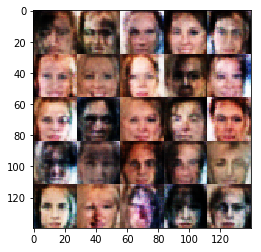

Epoch 1/1 - Batch 1010/6331:  Discriminator loss = 1.6730  Generator loss = 0.4038
Epoch 1/1 - Batch 1020/6331:  Discriminator loss = 1.1137  Generator loss = 0.7965
Epoch 1/1 - Batch 1030/6331:  Discriminator loss = 1.2758  Generator loss = 0.5807
Epoch 1/1 - Batch 1040/6331:  Discriminator loss = 1.2407  Generator loss = 0.5909
Epoch 1/1 - Batch 1050/6331:  Discriminator loss = 1.1710  Generator loss = 0.7218
Epoch 1/1 - Batch 1060/6331:  Discriminator loss = 1.0157  Generator loss = 0.9494
Epoch 1/1 - Batch 1070/6331:  Discriminator loss = 0.8970  Generator loss = 1.3098
Epoch 1/1 - Batch 1080/6331:  Discriminator loss = 1.3439  Generator loss = 0.5806
Epoch 1/1 - Batch 1090/6331:  Discriminator loss = 1.0679  Generator loss = 1.3855
Epoch 1/1 - Batch 1100/6331:  Discriminator loss = 1.1848  Generator loss = 0.7146


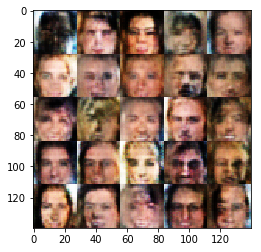

Epoch 1/1 - Batch 1110/6331:  Discriminator loss = 1.2791  Generator loss = 0.6240
Epoch 1/1 - Batch 1120/6331:  Discriminator loss = 1.4203  Generator loss = 0.5025
Epoch 1/1 - Batch 1130/6331:  Discriminator loss = 1.2168  Generator loss = 0.6520
Epoch 1/1 - Batch 1140/6331:  Discriminator loss = 1.1204  Generator loss = 0.7775
Epoch 1/1 - Batch 1150/6331:  Discriminator loss = 1.0146  Generator loss = 1.0621
Epoch 1/1 - Batch 1160/6331:  Discriminator loss = 1.1982  Generator loss = 1.4922
Epoch 1/1 - Batch 1170/6331:  Discriminator loss = 1.3857  Generator loss = 1.7108
Epoch 1/1 - Batch 1180/6331:  Discriminator loss = 1.0755  Generator loss = 1.2388
Epoch 1/1 - Batch 1190/6331:  Discriminator loss = 1.5574  Generator loss = 0.4267
Epoch 1/1 - Batch 1200/6331:  Discriminator loss = 0.9956  Generator loss = 0.9384


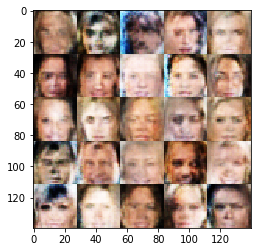

Epoch 1/1 - Batch 1210/6331:  Discriminator loss = 0.9694  Generator loss = 1.0650
Epoch 1/1 - Batch 1220/6331:  Discriminator loss = 1.0126  Generator loss = 0.9844
Epoch 1/1 - Batch 1230/6331:  Discriminator loss = 0.9516  Generator loss = 1.2291
Epoch 1/1 - Batch 1240/6331:  Discriminator loss = 1.0207  Generator loss = 1.0665
Epoch 1/1 - Batch 1250/6331:  Discriminator loss = 1.0354  Generator loss = 1.8686
Epoch 1/1 - Batch 1260/6331:  Discriminator loss = 1.0170  Generator loss = 0.8887
Epoch 1/1 - Batch 1270/6331:  Discriminator loss = 0.9792  Generator loss = 1.5465
Epoch 1/1 - Batch 1280/6331:  Discriminator loss = 0.8617  Generator loss = 1.1589
Epoch 1/1 - Batch 1290/6331:  Discriminator loss = 1.5559  Generator loss = 2.0137
Epoch 1/1 - Batch 1300/6331:  Discriminator loss = 1.3092  Generator loss = 0.6205


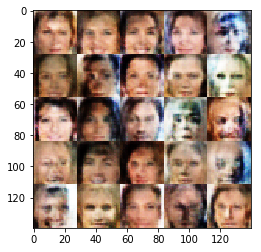

Epoch 1/1 - Batch 1310/6331:  Discriminator loss = 0.9900  Generator loss = 1.1357
Epoch 1/1 - Batch 1320/6331:  Discriminator loss = 1.0837  Generator loss = 0.9122
Epoch 1/1 - Batch 1330/6331:  Discriminator loss = 0.9246  Generator loss = 1.1433
Epoch 1/1 - Batch 1340/6331:  Discriminator loss = 1.0310  Generator loss = 0.9700
Epoch 1/1 - Batch 1350/6331:  Discriminator loss = 1.7336  Generator loss = 0.3504
Epoch 1/1 - Batch 1360/6331:  Discriminator loss = 0.9474  Generator loss = 1.3413
Epoch 1/1 - Batch 1370/6331:  Discriminator loss = 0.9825  Generator loss = 1.0575
Epoch 1/1 - Batch 1380/6331:  Discriminator loss = 1.5761  Generator loss = 0.4478
Epoch 1/1 - Batch 1390/6331:  Discriminator loss = 0.9057  Generator loss = 1.1085
Epoch 1/1 - Batch 1400/6331:  Discriminator loss = 0.8602  Generator loss = 1.3646


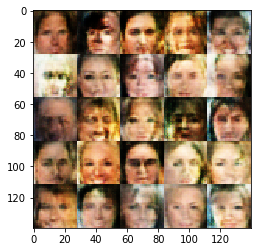

Epoch 1/1 - Batch 1410/6331:  Discriminator loss = 1.1145  Generator loss = 0.6966
Epoch 1/1 - Batch 1420/6331:  Discriminator loss = 1.1158  Generator loss = 1.2733
Epoch 1/1 - Batch 1430/6331:  Discriminator loss = 0.9617  Generator loss = 1.0207
Epoch 1/1 - Batch 1440/6331:  Discriminator loss = 1.1224  Generator loss = 2.1545
Epoch 1/1 - Batch 1450/6331:  Discriminator loss = 0.9559  Generator loss = 0.9427
Epoch 1/1 - Batch 1460/6331:  Discriminator loss = 1.1823  Generator loss = 0.7084
Epoch 1/1 - Batch 1470/6331:  Discriminator loss = 1.0461  Generator loss = 2.3919
Epoch 1/1 - Batch 1480/6331:  Discriminator loss = 1.0364  Generator loss = 1.7785
Epoch 1/1 - Batch 1490/6331:  Discriminator loss = 1.1005  Generator loss = 0.9952
Epoch 1/1 - Batch 1500/6331:  Discriminator loss = 1.1021  Generator loss = 0.9409


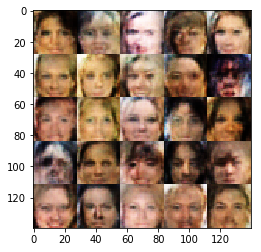

Epoch 1/1 - Batch 1510/6331:  Discriminator loss = 1.0605  Generator loss = 0.8196
Epoch 1/1 - Batch 1520/6331:  Discriminator loss = 0.9191  Generator loss = 1.7758
Epoch 1/1 - Batch 1530/6331:  Discriminator loss = 1.4534  Generator loss = 0.4725
Epoch 1/1 - Batch 1540/6331:  Discriminator loss = 0.9536  Generator loss = 1.2727
Epoch 1/1 - Batch 1550/6331:  Discriminator loss = 1.2809  Generator loss = 0.7389
Epoch 1/1 - Batch 1560/6331:  Discriminator loss = 0.8733  Generator loss = 1.3376
Epoch 1/1 - Batch 1570/6331:  Discriminator loss = 0.9034  Generator loss = 1.6218
Epoch 1/1 - Batch 1580/6331:  Discriminator loss = 0.7992  Generator loss = 1.4620
Epoch 1/1 - Batch 1590/6331:  Discriminator loss = 1.1717  Generator loss = 0.6901
Epoch 1/1 - Batch 1600/6331:  Discriminator loss = 0.9624  Generator loss = 1.5088


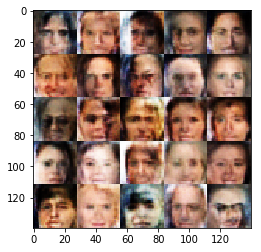

Epoch 1/1 - Batch 1610/6331:  Discriminator loss = 1.0375  Generator loss = 1.1027
Epoch 1/1 - Batch 1620/6331:  Discriminator loss = 0.9041  Generator loss = 1.4175
Epoch 1/1 - Batch 1630/6331:  Discriminator loss = 0.7950  Generator loss = 1.8452
Epoch 1/1 - Batch 1640/6331:  Discriminator loss = 0.9496  Generator loss = 0.9815
Epoch 1/1 - Batch 1650/6331:  Discriminator loss = 0.8798  Generator loss = 1.1079
Epoch 1/1 - Batch 1660/6331:  Discriminator loss = 0.9576  Generator loss = 1.3874
Epoch 1/1 - Batch 1670/6331:  Discriminator loss = 0.9229  Generator loss = 1.0775
Epoch 1/1 - Batch 1680/6331:  Discriminator loss = 0.7905  Generator loss = 1.5370
Epoch 1/1 - Batch 1690/6331:  Discriminator loss = 1.0189  Generator loss = 1.2736
Epoch 1/1 - Batch 1700/6331:  Discriminator loss = 0.9201  Generator loss = 1.5899


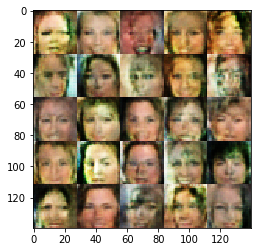

Epoch 1/1 - Batch 1710/6331:  Discriminator loss = 1.3376  Generator loss = 0.5393
Epoch 1/1 - Batch 1720/6331:  Discriminator loss = 1.1999  Generator loss = 0.6546
Epoch 1/1 - Batch 1730/6331:  Discriminator loss = 1.1393  Generator loss = 0.9896
Epoch 1/1 - Batch 1740/6331:  Discriminator loss = 0.8741  Generator loss = 1.1196
Epoch 1/1 - Batch 1750/6331:  Discriminator loss = 0.7959  Generator loss = 3.1816
Epoch 1/1 - Batch 1760/6331:  Discriminator loss = 1.2538  Generator loss = 0.6150
Epoch 1/1 - Batch 1770/6331:  Discriminator loss = 0.9193  Generator loss = 1.6238
Epoch 1/1 - Batch 1780/6331:  Discriminator loss = 1.2736  Generator loss = 0.6249
Epoch 1/1 - Batch 1790/6331:  Discriminator loss = 0.8827  Generator loss = 1.2476
Epoch 1/1 - Batch 1800/6331:  Discriminator loss = 0.8021  Generator loss = 1.8894


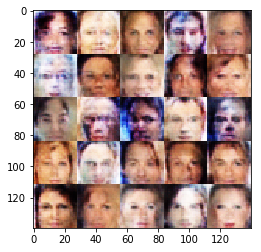

Epoch 1/1 - Batch 1810/6331:  Discriminator loss = 0.9743  Generator loss = 1.1430
Epoch 1/1 - Batch 1820/6331:  Discriminator loss = 1.0710  Generator loss = 0.7555
Epoch 1/1 - Batch 1830/6331:  Discriminator loss = 1.2302  Generator loss = 0.6647
Epoch 1/1 - Batch 1840/6331:  Discriminator loss = 0.9401  Generator loss = 1.0472
Epoch 1/1 - Batch 1850/6331:  Discriminator loss = 1.0105  Generator loss = 1.5726
Epoch 1/1 - Batch 1860/6331:  Discriminator loss = 1.0512  Generator loss = 0.8601
Epoch 1/1 - Batch 1870/6331:  Discriminator loss = 1.2733  Generator loss = 0.6483
Epoch 1/1 - Batch 1880/6331:  Discriminator loss = 1.0302  Generator loss = 0.8721
Epoch 1/1 - Batch 1890/6331:  Discriminator loss = 0.9791  Generator loss = 0.9621
Epoch 1/1 - Batch 1900/6331:  Discriminator loss = 1.0644  Generator loss = 1.8322


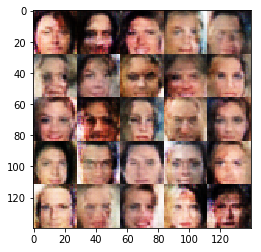

Epoch 1/1 - Batch 1910/6331:  Discriminator loss = 0.9259  Generator loss = 2.2675
Epoch 1/1 - Batch 1920/6331:  Discriminator loss = 2.1620  Generator loss = 0.2296
Epoch 1/1 - Batch 1930/6331:  Discriminator loss = 1.1736  Generator loss = 1.2027
Epoch 1/1 - Batch 1940/6331:  Discriminator loss = 0.8997  Generator loss = 1.1473
Epoch 1/1 - Batch 1950/6331:  Discriminator loss = 1.4048  Generator loss = 0.5402
Epoch 1/1 - Batch 1960/6331:  Discriminator loss = 0.8160  Generator loss = 1.3607
Epoch 1/1 - Batch 1970/6331:  Discriminator loss = 0.8504  Generator loss = 1.1803
Epoch 1/1 - Batch 1980/6331:  Discriminator loss = 0.7618  Generator loss = 1.3480
Epoch 1/1 - Batch 1990/6331:  Discriminator loss = 1.1870  Generator loss = 0.6678
Epoch 1/1 - Batch 2000/6331:  Discriminator loss = 0.8827  Generator loss = 1.0959


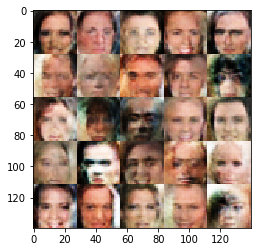

Epoch 1/1 - Batch 2010/6331:  Discriminator loss = 1.1434  Generator loss = 0.7313
Epoch 1/1 - Batch 2020/6331:  Discriminator loss = 0.8675  Generator loss = 1.1100
Epoch 1/1 - Batch 2030/6331:  Discriminator loss = 0.9911  Generator loss = 1.2029
Epoch 1/1 - Batch 2040/6331:  Discriminator loss = 0.9376  Generator loss = 1.8629
Epoch 1/1 - Batch 2050/6331:  Discriminator loss = 1.0412  Generator loss = 1.1080
Epoch 1/1 - Batch 2060/6331:  Discriminator loss = 0.8346  Generator loss = 1.3502
Epoch 1/1 - Batch 2070/6331:  Discriminator loss = 1.1279  Generator loss = 0.7770
Epoch 1/1 - Batch 2080/6331:  Discriminator loss = 1.1678  Generator loss = 2.2662
Epoch 1/1 - Batch 2090/6331:  Discriminator loss = 1.1494  Generator loss = 0.7013
Epoch 1/1 - Batch 2100/6331:  Discriminator loss = 1.0182  Generator loss = 1.3409


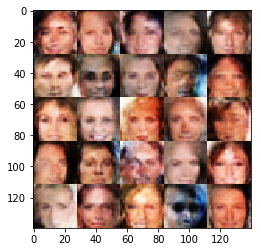

Epoch 1/1 - Batch 2110/6331:  Discriminator loss = 1.0369  Generator loss = 0.8755
Epoch 1/1 - Batch 2120/6331:  Discriminator loss = 1.5478  Generator loss = 0.4174
Epoch 1/1 - Batch 2130/6331:  Discriminator loss = 0.7000  Generator loss = 1.4940
Epoch 1/1 - Batch 2140/6331:  Discriminator loss = 0.7123  Generator loss = 1.5402
Epoch 1/1 - Batch 2150/6331:  Discriminator loss = 0.9129  Generator loss = 1.1775
Epoch 1/1 - Batch 2160/6331:  Discriminator loss = 0.9896  Generator loss = 0.9673
Epoch 1/1 - Batch 2170/6331:  Discriminator loss = 1.1564  Generator loss = 0.6874
Epoch 1/1 - Batch 2180/6331:  Discriminator loss = 0.5981  Generator loss = 1.9467
Epoch 1/1 - Batch 2190/6331:  Discriminator loss = 1.3776  Generator loss = 0.5585
Epoch 1/1 - Batch 2200/6331:  Discriminator loss = 0.9411  Generator loss = 1.2549


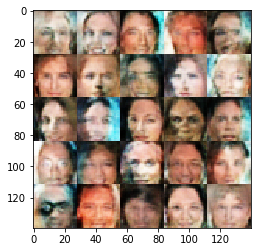

Epoch 1/1 - Batch 2210/6331:  Discriminator loss = 1.0333  Generator loss = 1.7805
Epoch 1/1 - Batch 2220/6331:  Discriminator loss = 0.9851  Generator loss = 1.5255
Epoch 1/1 - Batch 2230/6331:  Discriminator loss = 0.7986  Generator loss = 1.8582
Epoch 1/1 - Batch 2240/6331:  Discriminator loss = 1.3839  Generator loss = 0.5220
Epoch 1/1 - Batch 2250/6331:  Discriminator loss = 0.8502  Generator loss = 1.7522
Epoch 1/1 - Batch 2260/6331:  Discriminator loss = 1.2262  Generator loss = 0.6089
Epoch 1/1 - Batch 2270/6331:  Discriminator loss = 1.0201  Generator loss = 0.9412
Epoch 1/1 - Batch 2280/6331:  Discriminator loss = 0.7748  Generator loss = 1.9111
Epoch 1/1 - Batch 2290/6331:  Discriminator loss = 0.9768  Generator loss = 0.8752
Epoch 1/1 - Batch 2300/6331:  Discriminator loss = 0.7443  Generator loss = 2.1194


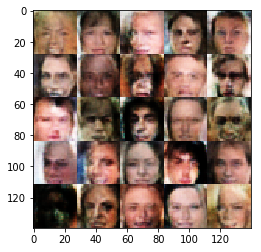

Epoch 1/1 - Batch 2310/6331:  Discriminator loss = 1.0343  Generator loss = 0.8635
Epoch 1/1 - Batch 2320/6331:  Discriminator loss = 1.3595  Generator loss = 0.5462
Epoch 1/1 - Batch 2330/6331:  Discriminator loss = 0.8738  Generator loss = 1.6294
Epoch 1/1 - Batch 2340/6331:  Discriminator loss = 1.2977  Generator loss = 0.5753
Epoch 1/1 - Batch 2350/6331:  Discriminator loss = 1.0559  Generator loss = 0.9768
Epoch 1/1 - Batch 2360/6331:  Discriminator loss = 1.2590  Generator loss = 0.6360
Epoch 1/1 - Batch 2370/6331:  Discriminator loss = 0.6692  Generator loss = 1.5129
Epoch 1/1 - Batch 2380/6331:  Discriminator loss = 1.1307  Generator loss = 0.7094
Epoch 1/1 - Batch 2390/6331:  Discriminator loss = 0.8258  Generator loss = 1.8466
Epoch 1/1 - Batch 2400/6331:  Discriminator loss = 0.8414  Generator loss = 1.2001


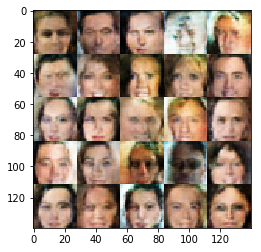

Epoch 1/1 - Batch 2410/6331:  Discriminator loss = 1.3792  Generator loss = 0.5933
Epoch 1/1 - Batch 2420/6331:  Discriminator loss = 0.9097  Generator loss = 1.2684
Epoch 1/1 - Batch 2430/6331:  Discriminator loss = 0.8178  Generator loss = 1.1006
Epoch 1/1 - Batch 2440/6331:  Discriminator loss = 0.8865  Generator loss = 1.0594
Epoch 1/1 - Batch 2450/6331:  Discriminator loss = 1.4097  Generator loss = 0.4678
Epoch 1/1 - Batch 2460/6331:  Discriminator loss = 1.2160  Generator loss = 0.6449
Epoch 1/1 - Batch 2470/6331:  Discriminator loss = 1.0162  Generator loss = 0.8362
Epoch 1/1 - Batch 2480/6331:  Discriminator loss = 0.9263  Generator loss = 1.0197
Epoch 1/1 - Batch 2490/6331:  Discriminator loss = 1.0411  Generator loss = 0.8445
Epoch 1/1 - Batch 2500/6331:  Discriminator loss = 0.8050  Generator loss = 1.2960


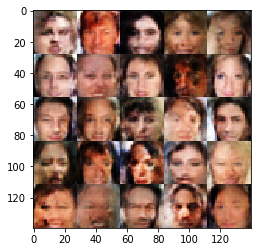

Epoch 1/1 - Batch 2510/6331:  Discriminator loss = 1.1310  Generator loss = 0.7853
Epoch 1/1 - Batch 2520/6331:  Discriminator loss = 0.8796  Generator loss = 1.2815
Epoch 1/1 - Batch 2530/6331:  Discriminator loss = 0.9125  Generator loss = 1.0114
Epoch 1/1 - Batch 2540/6331:  Discriminator loss = 0.6482  Generator loss = 1.8533
Epoch 1/1 - Batch 2550/6331:  Discriminator loss = 1.4760  Generator loss = 0.4808
Epoch 1/1 - Batch 2560/6331:  Discriminator loss = 0.7015  Generator loss = 2.3286
Epoch 1/1 - Batch 2570/6331:  Discriminator loss = 1.0334  Generator loss = 0.7951
Epoch 1/1 - Batch 2580/6331:  Discriminator loss = 0.9245  Generator loss = 1.1068
Epoch 1/1 - Batch 2590/6331:  Discriminator loss = 0.7875  Generator loss = 1.4015
Epoch 1/1 - Batch 2600/6331:  Discriminator loss = 0.9629  Generator loss = 1.0216


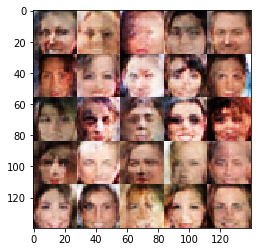

Epoch 1/1 - Batch 2610/6331:  Discriminator loss = 0.5114  Generator loss = 2.3084
Epoch 1/1 - Batch 2620/6331:  Discriminator loss = 0.8142  Generator loss = 1.1950
Epoch 1/1 - Batch 2630/6331:  Discriminator loss = 1.5896  Generator loss = 0.3746
Epoch 1/1 - Batch 2640/6331:  Discriminator loss = 0.9655  Generator loss = 0.9466
Epoch 1/1 - Batch 2650/6331:  Discriminator loss = 1.1162  Generator loss = 1.0690
Epoch 1/1 - Batch 2660/6331:  Discriminator loss = 1.1242  Generator loss = 0.8196
Epoch 1/1 - Batch 2670/6331:  Discriminator loss = 0.9317  Generator loss = 1.6513
Epoch 1/1 - Batch 2680/6331:  Discriminator loss = 1.5395  Generator loss = 2.4702
Epoch 1/1 - Batch 2690/6331:  Discriminator loss = 1.2106  Generator loss = 0.7789
Epoch 1/1 - Batch 2700/6331:  Discriminator loss = 1.2647  Generator loss = 0.7158


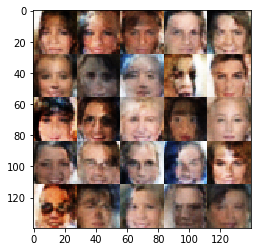

Epoch 1/1 - Batch 2710/6331:  Discriminator loss = 1.4437  Generator loss = 0.4801
Epoch 1/1 - Batch 2720/6331:  Discriminator loss = 0.9137  Generator loss = 1.4576
Epoch 1/1 - Batch 2730/6331:  Discriminator loss = 0.9988  Generator loss = 1.4640
Epoch 1/1 - Batch 2740/6331:  Discriminator loss = 1.7740  Generator loss = 0.3508
Epoch 1/1 - Batch 2750/6331:  Discriminator loss = 1.3645  Generator loss = 0.6619
Epoch 1/1 - Batch 2760/6331:  Discriminator loss = 1.0188  Generator loss = 0.8396
Epoch 1/1 - Batch 2770/6331:  Discriminator loss = 1.2338  Generator loss = 0.6605
Epoch 1/1 - Batch 2780/6331:  Discriminator loss = 0.7920  Generator loss = 1.3235
Epoch 1/1 - Batch 2790/6331:  Discriminator loss = 0.9460  Generator loss = 0.9523
Epoch 1/1 - Batch 2800/6331:  Discriminator loss = 1.0377  Generator loss = 0.9159


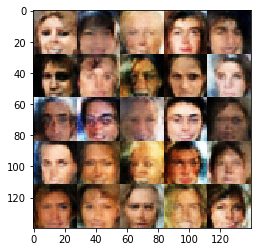

Epoch 1/1 - Batch 2810/6331:  Discriminator loss = 0.7826  Generator loss = 1.4514
Epoch 1/1 - Batch 2820/6331:  Discriminator loss = 0.7422  Generator loss = 1.4865
Epoch 1/1 - Batch 2830/6331:  Discriminator loss = 1.1059  Generator loss = 1.7750
Epoch 1/1 - Batch 2840/6331:  Discriminator loss = 0.9874  Generator loss = 1.1517
Epoch 1/1 - Batch 2850/6331:  Discriminator loss = 1.0512  Generator loss = 0.7952
Epoch 1/1 - Batch 2860/6331:  Discriminator loss = 0.7972  Generator loss = 1.3838
Epoch 1/1 - Batch 2870/6331:  Discriminator loss = 0.8052  Generator loss = 1.3474
Epoch 1/1 - Batch 2880/6331:  Discriminator loss = 1.2513  Generator loss = 0.6153
Epoch 1/1 - Batch 2890/6331:  Discriminator loss = 0.9708  Generator loss = 0.8989
Epoch 1/1 - Batch 2900/6331:  Discriminator loss = 1.0894  Generator loss = 0.7947


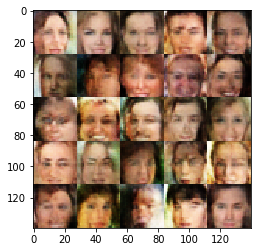

Epoch 1/1 - Batch 2910/6331:  Discriminator loss = 1.4943  Generator loss = 0.5073
Epoch 1/1 - Batch 2920/6331:  Discriminator loss = 1.6738  Generator loss = 0.3386
Epoch 1/1 - Batch 2930/6331:  Discriminator loss = 0.9996  Generator loss = 1.5352
Epoch 1/1 - Batch 2940/6331:  Discriminator loss = 0.8619  Generator loss = 1.1498
Epoch 1/1 - Batch 2950/6331:  Discriminator loss = 1.1176  Generator loss = 0.7274
Epoch 1/1 - Batch 2960/6331:  Discriminator loss = 0.7994  Generator loss = 2.4683
Epoch 1/1 - Batch 2970/6331:  Discriminator loss = 0.7022  Generator loss = 1.6970
Epoch 1/1 - Batch 2980/6331:  Discriminator loss = 0.9662  Generator loss = 1.1032
Epoch 1/1 - Batch 2990/6331:  Discriminator loss = 1.1725  Generator loss = 0.6658
Epoch 1/1 - Batch 3000/6331:  Discriminator loss = 1.2540  Generator loss = 0.5858


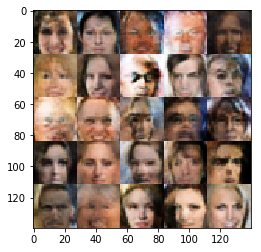

Epoch 1/1 - Batch 3010/6331:  Discriminator loss = 1.0530  Generator loss = 0.8295
Epoch 1/1 - Batch 3020/6331:  Discriminator loss = 1.0988  Generator loss = 0.9190
Epoch 1/1 - Batch 3030/6331:  Discriminator loss = 0.9845  Generator loss = 0.9849
Epoch 1/1 - Batch 3040/6331:  Discriminator loss = 1.1895  Generator loss = 0.6766
Epoch 1/1 - Batch 3050/6331:  Discriminator loss = 1.1978  Generator loss = 0.7653
Epoch 1/1 - Batch 3060/6331:  Discriminator loss = 0.6715  Generator loss = 1.6637
Epoch 1/1 - Batch 3070/6331:  Discriminator loss = 1.4577  Generator loss = 0.4631
Epoch 1/1 - Batch 3080/6331:  Discriminator loss = 1.1146  Generator loss = 0.7196
Epoch 1/1 - Batch 3090/6331:  Discriminator loss = 1.0108  Generator loss = 0.8468
Epoch 1/1 - Batch 3100/6331:  Discriminator loss = 1.5872  Generator loss = 0.4041


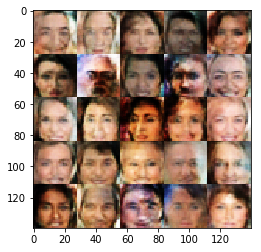

Epoch 1/1 - Batch 3110/6331:  Discriminator loss = 1.4154  Generator loss = 0.5007
Epoch 1/1 - Batch 3120/6331:  Discriminator loss = 1.1107  Generator loss = 0.7838
Epoch 1/1 - Batch 3130/6331:  Discriminator loss = 1.3664  Generator loss = 0.5078
Epoch 1/1 - Batch 3140/6331:  Discriminator loss = 1.0879  Generator loss = 0.9050
Epoch 1/1 - Batch 3150/6331:  Discriminator loss = 0.9756  Generator loss = 1.0631
Epoch 1/1 - Batch 3160/6331:  Discriminator loss = 1.1317  Generator loss = 0.7282
Epoch 1/1 - Batch 3170/6331:  Discriminator loss = 0.8043  Generator loss = 1.1889
Epoch 1/1 - Batch 3180/6331:  Discriminator loss = 0.8666  Generator loss = 2.7612
Epoch 1/1 - Batch 3190/6331:  Discriminator loss = 0.9035  Generator loss = 1.2596
Epoch 1/1 - Batch 3200/6331:  Discriminator loss = 1.4176  Generator loss = 0.4957


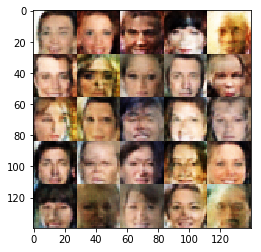

Epoch 1/1 - Batch 3210/6331:  Discriminator loss = 1.3673  Generator loss = 0.5743
Epoch 1/1 - Batch 3220/6331:  Discriminator loss = 0.9980  Generator loss = 0.9807
Epoch 1/1 - Batch 3230/6331:  Discriminator loss = 1.6304  Generator loss = 0.3948
Epoch 1/1 - Batch 3240/6331:  Discriminator loss = 0.8455  Generator loss = 1.6664
Epoch 1/1 - Batch 3250/6331:  Discriminator loss = 1.1041  Generator loss = 0.7711
Epoch 1/1 - Batch 3260/6331:  Discriminator loss = 1.1978  Generator loss = 0.6557
Epoch 1/1 - Batch 3270/6331:  Discriminator loss = 1.0735  Generator loss = 0.8633
Epoch 1/1 - Batch 3280/6331:  Discriminator loss = 0.9634  Generator loss = 1.6459
Epoch 1/1 - Batch 3290/6331:  Discriminator loss = 0.9368  Generator loss = 1.4389
Epoch 1/1 - Batch 3300/6331:  Discriminator loss = 1.0908  Generator loss = 0.8282


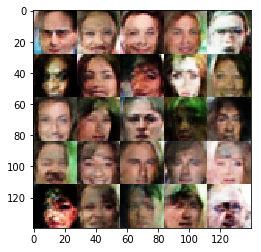

Epoch 1/1 - Batch 3310/6331:  Discriminator loss = 1.0369  Generator loss = 0.8144
Epoch 1/1 - Batch 3320/6331:  Discriminator loss = 0.7840  Generator loss = 1.4149
Epoch 1/1 - Batch 3330/6331:  Discriminator loss = 0.9487  Generator loss = 1.0233
Epoch 1/1 - Batch 3340/6331:  Discriminator loss = 0.7650  Generator loss = 1.4163
Epoch 1/1 - Batch 3350/6331:  Discriminator loss = 0.8443  Generator loss = 1.2821
Epoch 1/1 - Batch 3360/6331:  Discriminator loss = 1.3547  Generator loss = 0.5263
Epoch 1/1 - Batch 3370/6331:  Discriminator loss = 0.8792  Generator loss = 1.1861
Epoch 1/1 - Batch 3380/6331:  Discriminator loss = 0.8370  Generator loss = 1.3916
Epoch 1/1 - Batch 3390/6331:  Discriminator loss = 1.1597  Generator loss = 0.8131
Epoch 1/1 - Batch 3400/6331:  Discriminator loss = 0.8661  Generator loss = 2.1749


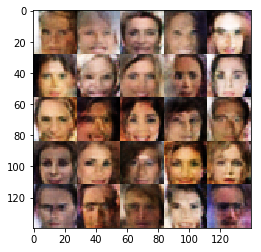

Epoch 1/1 - Batch 3410/6331:  Discriminator loss = 0.8289  Generator loss = 1.1389
Epoch 1/1 - Batch 3420/6331:  Discriminator loss = 0.9101  Generator loss = 0.9520
Epoch 1/1 - Batch 3430/6331:  Discriminator loss = 1.0154  Generator loss = 0.9311
Epoch 1/1 - Batch 3440/6331:  Discriminator loss = 1.0098  Generator loss = 0.8789
Epoch 1/1 - Batch 3450/6331:  Discriminator loss = 1.0523  Generator loss = 0.9053
Epoch 1/1 - Batch 3460/6331:  Discriminator loss = 0.9049  Generator loss = 0.9846
Epoch 1/1 - Batch 3470/6331:  Discriminator loss = 0.9535  Generator loss = 1.0093
Epoch 1/1 - Batch 3480/6331:  Discriminator loss = 0.8127  Generator loss = 1.2427
Epoch 1/1 - Batch 3490/6331:  Discriminator loss = 1.0085  Generator loss = 0.9533
Epoch 1/1 - Batch 3500/6331:  Discriminator loss = 0.9902  Generator loss = 1.5048


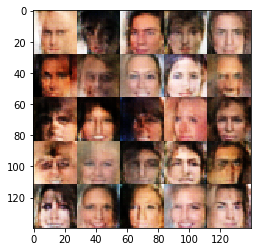

Epoch 1/1 - Batch 3510/6331:  Discriminator loss = 0.9139  Generator loss = 1.4831
Epoch 1/1 - Batch 3520/6331:  Discriminator loss = 0.9107  Generator loss = 1.2081
Epoch 1/1 - Batch 3530/6331:  Discriminator loss = 1.2155  Generator loss = 0.6560
Epoch 1/1 - Batch 3540/6331:  Discriminator loss = 1.1747  Generator loss = 1.4093
Epoch 1/1 - Batch 3550/6331:  Discriminator loss = 1.5065  Generator loss = 0.4550
Epoch 1/1 - Batch 3560/6331:  Discriminator loss = 0.9565  Generator loss = 1.3943
Epoch 1/1 - Batch 3570/6331:  Discriminator loss = 0.9104  Generator loss = 1.0418
Epoch 1/1 - Batch 3580/6331:  Discriminator loss = 1.2208  Generator loss = 0.6318
Epoch 1/1 - Batch 3590/6331:  Discriminator loss = 0.7479  Generator loss = 1.3604
Epoch 1/1 - Batch 3600/6331:  Discriminator loss = 1.3279  Generator loss = 0.5569


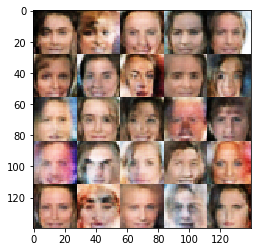

Epoch 1/1 - Batch 3610/6331:  Discriminator loss = 0.8307  Generator loss = 1.2953
Epoch 1/1 - Batch 3620/6331:  Discriminator loss = 1.8273  Generator loss = 0.3307
Epoch 1/1 - Batch 3630/6331:  Discriminator loss = 0.8522  Generator loss = 1.4810
Epoch 1/1 - Batch 3640/6331:  Discriminator loss = 1.3538  Generator loss = 0.6207
Epoch 1/1 - Batch 3650/6331:  Discriminator loss = 1.0826  Generator loss = 0.8002
Epoch 1/1 - Batch 3660/6331:  Discriminator loss = 1.3953  Generator loss = 0.5953
Epoch 1/1 - Batch 3670/6331:  Discriminator loss = 0.6616  Generator loss = 1.7405
Epoch 1/1 - Batch 3680/6331:  Discriminator loss = 0.8219  Generator loss = 1.3113
Epoch 1/1 - Batch 3690/6331:  Discriminator loss = 0.7793  Generator loss = 1.2937
Epoch 1/1 - Batch 3700/6331:  Discriminator loss = 1.5319  Generator loss = 0.4553


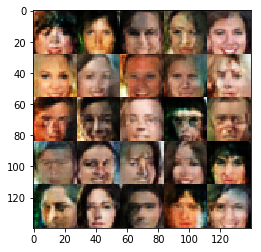

Epoch 1/1 - Batch 3710/6331:  Discriminator loss = 1.2319  Generator loss = 0.6328
Epoch 1/1 - Batch 3720/6331:  Discriminator loss = 0.8164  Generator loss = 1.8075
Epoch 1/1 - Batch 3730/6331:  Discriminator loss = 0.9565  Generator loss = 1.0674
Epoch 1/1 - Batch 3740/6331:  Discriminator loss = 1.0587  Generator loss = 1.9816
Epoch 1/1 - Batch 3750/6331:  Discriminator loss = 0.7943  Generator loss = 1.3211
Epoch 1/1 - Batch 3760/6331:  Discriminator loss = 0.8481  Generator loss = 2.1855
Epoch 1/1 - Batch 3770/6331:  Discriminator loss = 1.2676  Generator loss = 0.6542
Epoch 1/1 - Batch 3780/6331:  Discriminator loss = 0.9134  Generator loss = 0.9805
Epoch 1/1 - Batch 3790/6331:  Discriminator loss = 0.6526  Generator loss = 1.8661
Epoch 1/1 - Batch 3800/6331:  Discriminator loss = 1.4846  Generator loss = 0.4577


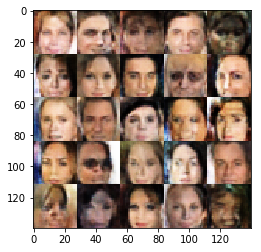

Epoch 1/1 - Batch 3810/6331:  Discriminator loss = 0.9953  Generator loss = 0.8761
Epoch 1/1 - Batch 3820/6331:  Discriminator loss = 1.7115  Generator loss = 0.3602
Epoch 1/1 - Batch 3830/6331:  Discriminator loss = 0.8057  Generator loss = 1.2788
Epoch 1/1 - Batch 3840/6331:  Discriminator loss = 0.9375  Generator loss = 1.2371
Epoch 1/1 - Batch 3850/6331:  Discriminator loss = 0.8281  Generator loss = 1.7708
Epoch 1/1 - Batch 3860/6331:  Discriminator loss = 0.8880  Generator loss = 1.7781
Epoch 1/1 - Batch 3870/6331:  Discriminator loss = 0.7745  Generator loss = 1.3154
Epoch 1/1 - Batch 3880/6331:  Discriminator loss = 1.2067  Generator loss = 2.1994
Epoch 1/1 - Batch 3890/6331:  Discriminator loss = 1.1018  Generator loss = 1.0372
Epoch 1/1 - Batch 3900/6331:  Discriminator loss = 0.7676  Generator loss = 1.5615


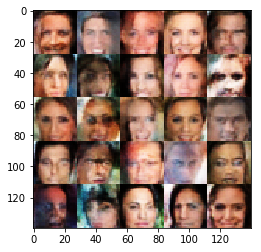

Epoch 1/1 - Batch 3910/6331:  Discriminator loss = 0.7155  Generator loss = 1.5237
Epoch 1/1 - Batch 3920/6331:  Discriminator loss = 0.8957  Generator loss = 1.1809
Epoch 1/1 - Batch 3930/6331:  Discriminator loss = 0.9176  Generator loss = 1.9352
Epoch 1/1 - Batch 3940/6331:  Discriminator loss = 1.0591  Generator loss = 0.8101
Epoch 1/1 - Batch 3950/6331:  Discriminator loss = 0.9188  Generator loss = 0.9904
Epoch 1/1 - Batch 3960/6331:  Discriminator loss = 1.1983  Generator loss = 0.6327
Epoch 1/1 - Batch 3970/6331:  Discriminator loss = 1.4593  Generator loss = 0.5032
Epoch 1/1 - Batch 3980/6331:  Discriminator loss = 0.8884  Generator loss = 1.1002
Epoch 1/1 - Batch 3990/6331:  Discriminator loss = 1.3475  Generator loss = 0.5359
Epoch 1/1 - Batch 4000/6331:  Discriminator loss = 1.1107  Generator loss = 0.8172


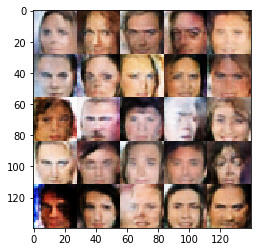

Epoch 1/1 - Batch 4010/6331:  Discriminator loss = 0.9454  Generator loss = 1.1447
Epoch 1/1 - Batch 4020/6331:  Discriminator loss = 0.6760  Generator loss = 1.7649
Epoch 1/1 - Batch 4030/6331:  Discriminator loss = 0.8086  Generator loss = 1.5128
Epoch 1/1 - Batch 4040/6331:  Discriminator loss = 1.2377  Generator loss = 0.6427
Epoch 1/1 - Batch 4050/6331:  Discriminator loss = 0.8455  Generator loss = 1.3311
Epoch 1/1 - Batch 4060/6331:  Discriminator loss = 1.1830  Generator loss = 0.6962
Epoch 1/1 - Batch 4070/6331:  Discriminator loss = 0.8617  Generator loss = 1.2245
Epoch 1/1 - Batch 4080/6331:  Discriminator loss = 0.7483  Generator loss = 2.0369
Epoch 1/1 - Batch 4090/6331:  Discriminator loss = 1.6214  Generator loss = 0.3869
Epoch 1/1 - Batch 4100/6331:  Discriminator loss = 0.8957  Generator loss = 0.9928


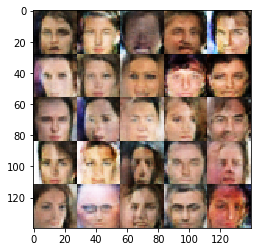

Epoch 1/1 - Batch 4110/6331:  Discriminator loss = 1.5721  Generator loss = 0.4454
Epoch 1/1 - Batch 4120/6331:  Discriminator loss = 1.0087  Generator loss = 0.8904
Epoch 1/1 - Batch 4130/6331:  Discriminator loss = 1.0271  Generator loss = 0.8272
Epoch 1/1 - Batch 4140/6331:  Discriminator loss = 1.0796  Generator loss = 0.8214
Epoch 1/1 - Batch 4150/6331:  Discriminator loss = 0.8543  Generator loss = 1.6803
Epoch 1/1 - Batch 4160/6331:  Discriminator loss = 1.0463  Generator loss = 0.8300
Epoch 1/1 - Batch 4170/6331:  Discriminator loss = 1.5194  Generator loss = 0.4803
Epoch 1/1 - Batch 4180/6331:  Discriminator loss = 1.1180  Generator loss = 0.7432
Epoch 1/1 - Batch 4190/6331:  Discriminator loss = 0.7767  Generator loss = 1.3298
Epoch 1/1 - Batch 4200/6331:  Discriminator loss = 0.9012  Generator loss = 1.2167


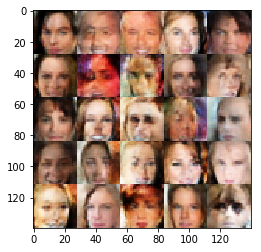

Epoch 1/1 - Batch 4210/6331:  Discriminator loss = 0.7303  Generator loss = 1.3930
Epoch 1/1 - Batch 4220/6331:  Discriminator loss = 1.5645  Generator loss = 0.4733
Epoch 1/1 - Batch 4230/6331:  Discriminator loss = 1.1313  Generator loss = 0.7705
Epoch 1/1 - Batch 4240/6331:  Discriminator loss = 1.0168  Generator loss = 1.0008
Epoch 1/1 - Batch 4250/6331:  Discriminator loss = 0.8472  Generator loss = 1.1649
Epoch 1/1 - Batch 4260/6331:  Discriminator loss = 1.0354  Generator loss = 1.8287
Epoch 1/1 - Batch 4270/6331:  Discriminator loss = 1.2268  Generator loss = 0.6305
Epoch 1/1 - Batch 4280/6331:  Discriminator loss = 0.5021  Generator loss = 2.2627
Epoch 1/1 - Batch 4290/6331:  Discriminator loss = 1.0194  Generator loss = 0.8687
Epoch 1/1 - Batch 4300/6331:  Discriminator loss = 0.9581  Generator loss = 1.0069


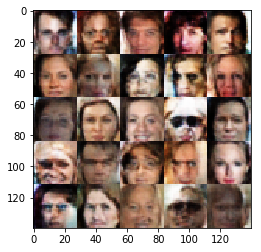

Epoch 1/1 - Batch 4310/6331:  Discriminator loss = 0.7757  Generator loss = 1.5198
Epoch 1/1 - Batch 4320/6331:  Discriminator loss = 1.7463  Generator loss = 0.4112
Epoch 1/1 - Batch 4330/6331:  Discriminator loss = 1.1838  Generator loss = 0.7136
Epoch 1/1 - Batch 4340/6331:  Discriminator loss = 1.1238  Generator loss = 0.7354
Epoch 1/1 - Batch 4350/6331:  Discriminator loss = 1.1359  Generator loss = 0.8509
Epoch 1/1 - Batch 4360/6331:  Discriminator loss = 1.0207  Generator loss = 0.8156
Epoch 1/1 - Batch 4370/6331:  Discriminator loss = 1.6337  Generator loss = 0.3939
Epoch 1/1 - Batch 4380/6331:  Discriminator loss = 0.8756  Generator loss = 1.0266
Epoch 1/1 - Batch 4390/6331:  Discriminator loss = 0.8816  Generator loss = 0.9753
Epoch 1/1 - Batch 4400/6331:  Discriminator loss = 0.8531  Generator loss = 1.6042


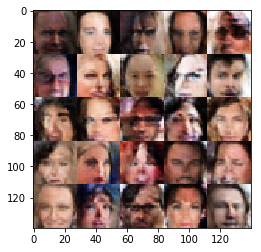

Epoch 1/1 - Batch 4410/6331:  Discriminator loss = 0.9958  Generator loss = 0.8386
Epoch 1/1 - Batch 4420/6331:  Discriminator loss = 0.7609  Generator loss = 1.3064
Epoch 1/1 - Batch 4430/6331:  Discriminator loss = 0.7879  Generator loss = 1.8728
Epoch 1/1 - Batch 4440/6331:  Discriminator loss = 1.1503  Generator loss = 0.7068
Epoch 1/1 - Batch 4450/6331:  Discriminator loss = 1.0342  Generator loss = 1.1764
Epoch 1/1 - Batch 4460/6331:  Discriminator loss = 1.1984  Generator loss = 0.6820
Epoch 1/1 - Batch 4470/6331:  Discriminator loss = 1.3802  Generator loss = 0.5399
Epoch 1/1 - Batch 4480/6331:  Discriminator loss = 1.4387  Generator loss = 0.4656
Epoch 1/1 - Batch 4490/6331:  Discriminator loss = 0.5005  Generator loss = 2.3599
Epoch 1/1 - Batch 4500/6331:  Discriminator loss = 0.9281  Generator loss = 1.1157


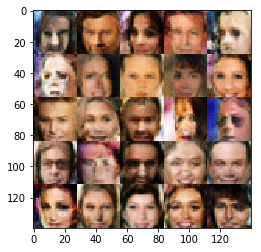

Epoch 1/1 - Batch 4510/6331:  Discriminator loss = 1.2635  Generator loss = 0.6296
Epoch 1/1 - Batch 4520/6331:  Discriminator loss = 1.0592  Generator loss = 0.8587
Epoch 1/1 - Batch 4530/6331:  Discriminator loss = 1.0886  Generator loss = 1.0902
Epoch 1/1 - Batch 4540/6331:  Discriminator loss = 1.1485  Generator loss = 0.7245
Epoch 1/1 - Batch 4550/6331:  Discriminator loss = 1.1271  Generator loss = 0.7926
Epoch 1/1 - Batch 4560/6331:  Discriminator loss = 0.9652  Generator loss = 0.9875
Epoch 1/1 - Batch 4570/6331:  Discriminator loss = 1.1203  Generator loss = 0.8327
Epoch 1/1 - Batch 4580/6331:  Discriminator loss = 1.5864  Generator loss = 0.4221
Epoch 1/1 - Batch 4590/6331:  Discriminator loss = 1.5274  Generator loss = 0.4807
Epoch 1/1 - Batch 4600/6331:  Discriminator loss = 0.7598  Generator loss = 1.6007


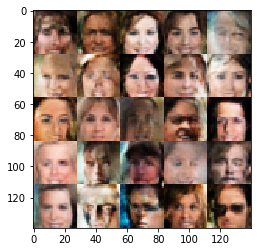

Epoch 1/1 - Batch 4610/6331:  Discriminator loss = 1.2622  Generator loss = 0.6008
Epoch 1/1 - Batch 4620/6331:  Discriminator loss = 1.0085  Generator loss = 0.8602
Epoch 1/1 - Batch 4630/6331:  Discriminator loss = 1.0514  Generator loss = 1.1982
Epoch 1/1 - Batch 4640/6331:  Discriminator loss = 0.9083  Generator loss = 0.9942
Epoch 1/1 - Batch 4650/6331:  Discriminator loss = 0.7539  Generator loss = 1.4245
Epoch 1/1 - Batch 4660/6331:  Discriminator loss = 0.9803  Generator loss = 0.9137
Epoch 1/1 - Batch 4670/6331:  Discriminator loss = 1.0156  Generator loss = 0.8690
Epoch 1/1 - Batch 4680/6331:  Discriminator loss = 1.5403  Generator loss = 0.4567
Epoch 1/1 - Batch 4690/6331:  Discriminator loss = 1.0120  Generator loss = 1.1710
Epoch 1/1 - Batch 4700/6331:  Discriminator loss = 1.0049  Generator loss = 0.9686


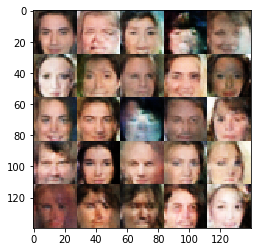

Epoch 1/1 - Batch 4710/6331:  Discriminator loss = 0.9597  Generator loss = 0.9866
Epoch 1/1 - Batch 4720/6331:  Discriminator loss = 1.3427  Generator loss = 0.5566
Epoch 1/1 - Batch 4730/6331:  Discriminator loss = 1.2209  Generator loss = 0.6430
Epoch 1/1 - Batch 4740/6331:  Discriminator loss = 0.8092  Generator loss = 1.2932
Epoch 1/1 - Batch 4750/6331:  Discriminator loss = 0.9226  Generator loss = 1.2626
Epoch 1/1 - Batch 4760/6331:  Discriminator loss = 0.8680  Generator loss = 1.5794
Epoch 1/1 - Batch 4770/6331:  Discriminator loss = 1.2970  Generator loss = 0.6140
Epoch 1/1 - Batch 4780/6331:  Discriminator loss = 1.0896  Generator loss = 0.9015
Epoch 1/1 - Batch 4790/6331:  Discriminator loss = 0.8273  Generator loss = 1.3762
Epoch 1/1 - Batch 4800/6331:  Discriminator loss = 0.8950  Generator loss = 1.0476


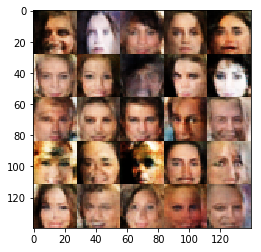

Epoch 1/1 - Batch 4810/6331:  Discriminator loss = 1.2666  Generator loss = 0.5716
Epoch 1/1 - Batch 4820/6331:  Discriminator loss = 0.8512  Generator loss = 1.1833
Epoch 1/1 - Batch 4830/6331:  Discriminator loss = 0.9684  Generator loss = 0.9214
Epoch 1/1 - Batch 4840/6331:  Discriminator loss = 0.6861  Generator loss = 1.8262
Epoch 1/1 - Batch 4850/6331:  Discriminator loss = 0.8923  Generator loss = 1.0347
Epoch 1/1 - Batch 4860/6331:  Discriminator loss = 0.8613  Generator loss = 1.0494
Epoch 1/1 - Batch 4870/6331:  Discriminator loss = 0.8058  Generator loss = 1.3702
Epoch 1/1 - Batch 4880/6331:  Discriminator loss = 1.2775  Generator loss = 0.5807
Epoch 1/1 - Batch 4890/6331:  Discriminator loss = 2.0988  Generator loss = 0.2632
Epoch 1/1 - Batch 4900/6331:  Discriminator loss = 1.2377  Generator loss = 0.6149


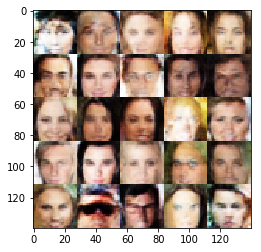

Epoch 1/1 - Batch 4910/6331:  Discriminator loss = 0.8825  Generator loss = 1.0917
Epoch 1/1 - Batch 4920/6331:  Discriminator loss = 1.0781  Generator loss = 0.8302
Epoch 1/1 - Batch 4930/6331:  Discriminator loss = 0.6844  Generator loss = 1.5963
Epoch 1/1 - Batch 4940/6331:  Discriminator loss = 1.0200  Generator loss = 0.9775
Epoch 1/1 - Batch 4950/6331:  Discriminator loss = 0.6939  Generator loss = 2.0701
Epoch 1/1 - Batch 4960/6331:  Discriminator loss = 0.9565  Generator loss = 1.0775
Epoch 1/1 - Batch 4970/6331:  Discriminator loss = 1.6190  Generator loss = 0.3846
Epoch 1/1 - Batch 4980/6331:  Discriminator loss = 0.8707  Generator loss = 1.5072
Epoch 1/1 - Batch 4990/6331:  Discriminator loss = 1.0550  Generator loss = 1.6354
Epoch 1/1 - Batch 5000/6331:  Discriminator loss = 1.4789  Generator loss = 0.4702


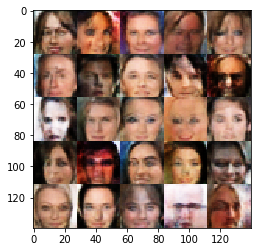

Epoch 1/1 - Batch 5010/6331:  Discriminator loss = 1.3477  Generator loss = 0.5587
Epoch 1/1 - Batch 5020/6331:  Discriminator loss = 1.5060  Generator loss = 0.4158
Epoch 1/1 - Batch 5030/6331:  Discriminator loss = 0.8874  Generator loss = 1.3618
Epoch 1/1 - Batch 5040/6331:  Discriminator loss = 0.8554  Generator loss = 1.2448
Epoch 1/1 - Batch 5050/6331:  Discriminator loss = 1.0528  Generator loss = 0.8684
Epoch 1/1 - Batch 5060/6331:  Discriminator loss = 0.8986  Generator loss = 2.1808
Epoch 1/1 - Batch 5070/6331:  Discriminator loss = 0.9520  Generator loss = 1.1542
Epoch 1/1 - Batch 5080/6331:  Discriminator loss = 0.7348  Generator loss = 1.4877
Epoch 1/1 - Batch 5090/6331:  Discriminator loss = 1.0075  Generator loss = 1.9813
Epoch 1/1 - Batch 5100/6331:  Discriminator loss = 0.8563  Generator loss = 1.2912


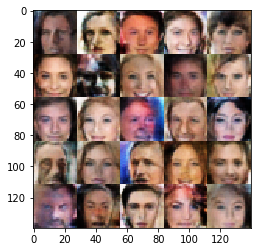

Epoch 1/1 - Batch 5110/6331:  Discriminator loss = 0.7654  Generator loss = 1.9862
Epoch 1/1 - Batch 5120/6331:  Discriminator loss = 0.7061  Generator loss = 1.6060
Epoch 1/1 - Batch 5130/6331:  Discriminator loss = 0.8112  Generator loss = 1.3502
Epoch 1/1 - Batch 5140/6331:  Discriminator loss = 1.1326  Generator loss = 0.6968
Epoch 1/1 - Batch 5150/6331:  Discriminator loss = 0.8038  Generator loss = 1.3989
Epoch 1/1 - Batch 5160/6331:  Discriminator loss = 1.0239  Generator loss = 0.9041
Epoch 1/1 - Batch 5170/6331:  Discriminator loss = 0.7692  Generator loss = 1.8238
Epoch 1/1 - Batch 5180/6331:  Discriminator loss = 0.8384  Generator loss = 1.8616
Epoch 1/1 - Batch 5190/6331:  Discriminator loss = 1.0482  Generator loss = 0.8206
Epoch 1/1 - Batch 5200/6331:  Discriminator loss = 0.6400  Generator loss = 1.5467


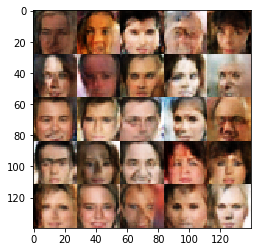

Epoch 1/1 - Batch 5210/6331:  Discriminator loss = 1.0899  Generator loss = 2.0849
Epoch 1/1 - Batch 5220/6331:  Discriminator loss = 1.2925  Generator loss = 0.5794
Epoch 1/1 - Batch 5230/6331:  Discriminator loss = 0.6647  Generator loss = 1.6924
Epoch 1/1 - Batch 5240/6331:  Discriminator loss = 0.7576  Generator loss = 1.5450
Epoch 1/1 - Batch 5250/6331:  Discriminator loss = 1.2159  Generator loss = 0.6562
Epoch 1/1 - Batch 5260/6331:  Discriminator loss = 0.9974  Generator loss = 2.4821
Epoch 1/1 - Batch 5270/6331:  Discriminator loss = 1.3099  Generator loss = 0.7254
Epoch 1/1 - Batch 5280/6331:  Discriminator loss = 0.9467  Generator loss = 1.1063
Epoch 1/1 - Batch 5290/6331:  Discriminator loss = 0.8003  Generator loss = 1.2295
Epoch 1/1 - Batch 5300/6331:  Discriminator loss = 1.0249  Generator loss = 1.0151


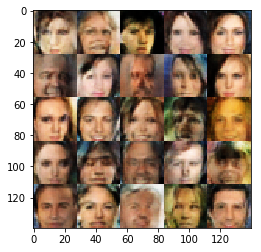

Epoch 1/1 - Batch 5310/6331:  Discriminator loss = 0.8856  Generator loss = 1.3947
Epoch 1/1 - Batch 5320/6331:  Discriminator loss = 0.9688  Generator loss = 1.0217
Epoch 1/1 - Batch 5330/6331:  Discriminator loss = 1.1722  Generator loss = 0.6554
Epoch 1/1 - Batch 5340/6331:  Discriminator loss = 0.8595  Generator loss = 1.4535
Epoch 1/1 - Batch 5350/6331:  Discriminator loss = 1.6489  Generator loss = 0.3694
Epoch 1/1 - Batch 5360/6331:  Discriminator loss = 1.0723  Generator loss = 0.8053
Epoch 1/1 - Batch 5370/6331:  Discriminator loss = 1.2687  Generator loss = 0.6039
Epoch 1/1 - Batch 5380/6331:  Discriminator loss = 0.8521  Generator loss = 1.1108
Epoch 1/1 - Batch 5390/6331:  Discriminator loss = 1.1390  Generator loss = 0.7591
Epoch 1/1 - Batch 5400/6331:  Discriminator loss = 0.8259  Generator loss = 1.1191


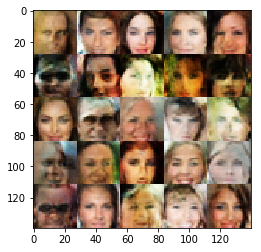

Epoch 1/1 - Batch 5410/6331:  Discriminator loss = 1.2544  Generator loss = 0.7368
Epoch 1/1 - Batch 5420/6331:  Discriminator loss = 0.8863  Generator loss = 1.4983
Epoch 1/1 - Batch 5430/6331:  Discriminator loss = 0.6499  Generator loss = 1.8890
Epoch 1/1 - Batch 5440/6331:  Discriminator loss = 0.7450  Generator loss = 1.4082
Epoch 1/1 - Batch 5450/6331:  Discriminator loss = 0.6983  Generator loss = 1.3603
Epoch 1/1 - Batch 5460/6331:  Discriminator loss = 0.9488  Generator loss = 1.0868
Epoch 1/1 - Batch 5470/6331:  Discriminator loss = 1.3106  Generator loss = 0.6942
Epoch 1/1 - Batch 5480/6331:  Discriminator loss = 1.6177  Generator loss = 0.4211
Epoch 1/1 - Batch 5490/6331:  Discriminator loss = 1.0654  Generator loss = 1.0950
Epoch 1/1 - Batch 5500/6331:  Discriminator loss = 1.0442  Generator loss = 1.6379


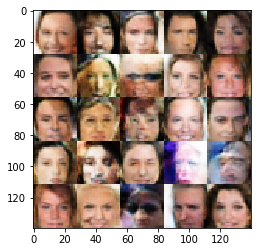

Epoch 1/1 - Batch 5510/6331:  Discriminator loss = 0.7682  Generator loss = 2.0104
Epoch 1/1 - Batch 5520/6331:  Discriminator loss = 0.9820  Generator loss = 0.9013
Epoch 1/1 - Batch 5530/6331:  Discriminator loss = 0.8785  Generator loss = 1.1622
Epoch 1/1 - Batch 5540/6331:  Discriminator loss = 1.0878  Generator loss = 0.7750
Epoch 1/1 - Batch 5550/6331:  Discriminator loss = 0.9883  Generator loss = 0.9418
Epoch 1/1 - Batch 5560/6331:  Discriminator loss = 0.9763  Generator loss = 0.9276
Epoch 1/1 - Batch 5570/6331:  Discriminator loss = 1.4406  Generator loss = 0.5057
Epoch 1/1 - Batch 5580/6331:  Discriminator loss = 0.6745  Generator loss = 2.1924
Epoch 1/1 - Batch 5590/6331:  Discriminator loss = 1.7306  Generator loss = 0.3357
Epoch 1/1 - Batch 5600/6331:  Discriminator loss = 0.7905  Generator loss = 1.2242


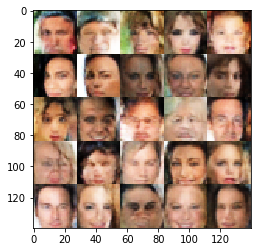

Epoch 1/1 - Batch 5610/6331:  Discriminator loss = 0.9004  Generator loss = 1.0685
Epoch 1/1 - Batch 5620/6331:  Discriminator loss = 0.9366  Generator loss = 1.4878
Epoch 1/1 - Batch 5630/6331:  Discriminator loss = 0.9137  Generator loss = 1.0131
Epoch 1/1 - Batch 5640/6331:  Discriminator loss = 0.8457  Generator loss = 1.1182
Epoch 1/1 - Batch 5650/6331:  Discriminator loss = 0.7107  Generator loss = 1.7796
Epoch 1/1 - Batch 5660/6331:  Discriminator loss = 0.8727  Generator loss = 1.1041
Epoch 1/1 - Batch 5670/6331:  Discriminator loss = 0.7397  Generator loss = 1.9836
Epoch 1/1 - Batch 5680/6331:  Discriminator loss = 0.9497  Generator loss = 1.0898
Epoch 1/1 - Batch 5690/6331:  Discriminator loss = 0.7651  Generator loss = 1.5609
Epoch 1/1 - Batch 5700/6331:  Discriminator loss = 0.7117  Generator loss = 1.4839


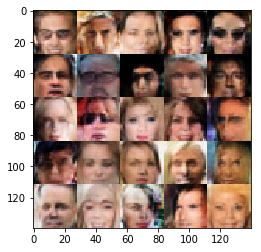

Epoch 1/1 - Batch 5710/6331:  Discriminator loss = 0.6963  Generator loss = 1.4964
Epoch 1/1 - Batch 5720/6331:  Discriminator loss = 0.7526  Generator loss = 1.3091
Epoch 1/1 - Batch 5730/6331:  Discriminator loss = 1.3256  Generator loss = 0.5539
Epoch 1/1 - Batch 5740/6331:  Discriminator loss = 1.4586  Generator loss = 0.5057
Epoch 1/1 - Batch 5750/6331:  Discriminator loss = 1.1770  Generator loss = 0.7814
Epoch 1/1 - Batch 5760/6331:  Discriminator loss = 0.9121  Generator loss = 1.6931
Epoch 1/1 - Batch 5770/6331:  Discriminator loss = 1.1183  Generator loss = 0.7251
Epoch 1/1 - Batch 5780/6331:  Discriminator loss = 1.0458  Generator loss = 0.9925
Epoch 1/1 - Batch 5790/6331:  Discriminator loss = 0.8630  Generator loss = 1.1101
Epoch 1/1 - Batch 5800/6331:  Discriminator loss = 1.2419  Generator loss = 0.7308


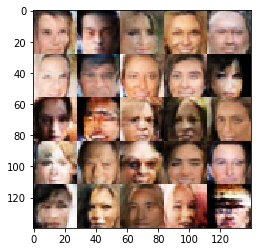

Epoch 1/1 - Batch 5810/6331:  Discriminator loss = 0.9458  Generator loss = 1.0312
Epoch 1/1 - Batch 5820/6331:  Discriminator loss = 1.0027  Generator loss = 0.8246
Epoch 1/1 - Batch 5830/6331:  Discriminator loss = 1.0157  Generator loss = 0.8618
Epoch 1/1 - Batch 5840/6331:  Discriminator loss = 0.7342  Generator loss = 2.8499
Epoch 1/1 - Batch 5850/6331:  Discriminator loss = 0.7910  Generator loss = 1.4373
Epoch 1/1 - Batch 5860/6331:  Discriminator loss = 0.9050  Generator loss = 1.1347
Epoch 1/1 - Batch 5870/6331:  Discriminator loss = 0.6885  Generator loss = 1.6523
Epoch 1/1 - Batch 5880/6331:  Discriminator loss = 1.6433  Generator loss = 0.4554
Epoch 1/1 - Batch 5890/6331:  Discriminator loss = 1.5266  Generator loss = 0.4616
Epoch 1/1 - Batch 5900/6331:  Discriminator loss = 1.1397  Generator loss = 0.7534


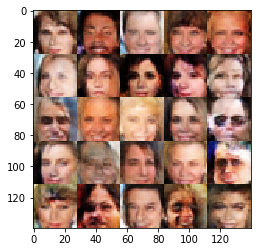

Epoch 1/1 - Batch 5910/6331:  Discriminator loss = 1.0692  Generator loss = 0.8953
Epoch 1/1 - Batch 5920/6331:  Discriminator loss = 1.3769  Generator loss = 0.5692
Epoch 1/1 - Batch 5930/6331:  Discriminator loss = 1.0262  Generator loss = 1.1483
Epoch 1/1 - Batch 5940/6331:  Discriminator loss = 0.7311  Generator loss = 2.1331
Epoch 1/1 - Batch 5950/6331:  Discriminator loss = 0.5948  Generator loss = 1.6282
Epoch 1/1 - Batch 5960/6331:  Discriminator loss = 1.2495  Generator loss = 0.5818
Epoch 1/1 - Batch 5970/6331:  Discriminator loss = 1.1274  Generator loss = 0.7286
Epoch 1/1 - Batch 5980/6331:  Discriminator loss = 0.9279  Generator loss = 1.9561
Epoch 1/1 - Batch 5990/6331:  Discriminator loss = 0.8255  Generator loss = 1.3639
Epoch 1/1 - Batch 6000/6331:  Discriminator loss = 1.1421  Generator loss = 0.6972


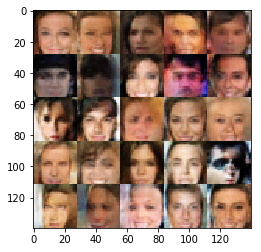

Epoch 1/1 - Batch 6010/6331:  Discriminator loss = 0.8574  Generator loss = 1.3629
Epoch 1/1 - Batch 6020/6331:  Discriminator loss = 0.9975  Generator loss = 1.2535
Epoch 1/1 - Batch 6030/6331:  Discriminator loss = 1.0458  Generator loss = 0.7912
Epoch 1/1 - Batch 6040/6331:  Discriminator loss = 1.2102  Generator loss = 0.6829
Epoch 1/1 - Batch 6050/6331:  Discriminator loss = 1.4072  Generator loss = 0.5432
Epoch 1/1 - Batch 6060/6331:  Discriminator loss = 0.9894  Generator loss = 1.5838
Epoch 1/1 - Batch 6070/6331:  Discriminator loss = 1.2002  Generator loss = 0.6099
Epoch 1/1 - Batch 6080/6331:  Discriminator loss = 0.8705  Generator loss = 1.5757
Epoch 1/1 - Batch 6090/6331:  Discriminator loss = 1.4496  Generator loss = 0.5209
Epoch 1/1 - Batch 6100/6331:  Discriminator loss = 1.7630  Generator loss = 0.4451


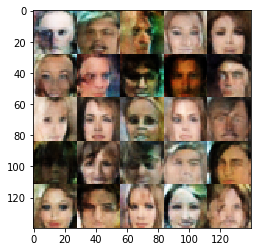

Epoch 1/1 - Batch 6110/6331:  Discriminator loss = 0.6504  Generator loss = 1.7860
Epoch 1/1 - Batch 6120/6331:  Discriminator loss = 1.3705  Generator loss = 2.0223
Epoch 1/1 - Batch 6130/6331:  Discriminator loss = 0.7775  Generator loss = 1.7647
Epoch 1/1 - Batch 6140/6331:  Discriminator loss = 0.8911  Generator loss = 1.1523
Epoch 1/1 - Batch 6150/6331:  Discriminator loss = 1.1552  Generator loss = 0.6849
Epoch 1/1 - Batch 6160/6331:  Discriminator loss = 0.9270  Generator loss = 1.0082
Epoch 1/1 - Batch 6170/6331:  Discriminator loss = 1.1784  Generator loss = 0.7309
Epoch 1/1 - Batch 6180/6331:  Discriminator loss = 0.7423  Generator loss = 1.3510
Epoch 1/1 - Batch 6190/6331:  Discriminator loss = 0.8609  Generator loss = 1.7043
Epoch 1/1 - Batch 6200/6331:  Discriminator loss = 1.0567  Generator loss = 0.7891


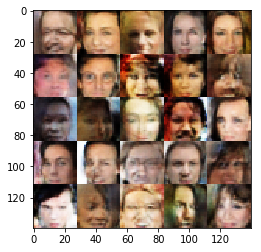

Epoch 1/1 - Batch 6210/6331:  Discriminator loss = 0.8432  Generator loss = 1.0925
Epoch 1/1 - Batch 6220/6331:  Discriminator loss = 1.3856  Generator loss = 0.5301
Epoch 1/1 - Batch 6230/6331:  Discriminator loss = 1.5130  Generator loss = 0.4579
Epoch 1/1 - Batch 6240/6331:  Discriminator loss = 0.6607  Generator loss = 1.6374
Epoch 1/1 - Batch 6250/6331:  Discriminator loss = 0.8622  Generator loss = 1.3478
Epoch 1/1 - Batch 6260/6331:  Discriminator loss = 0.7421  Generator loss = 2.2928
Epoch 1/1 - Batch 6270/6331:  Discriminator loss = 0.6727  Generator loss = 2.1419
Epoch 1/1 - Batch 6280/6331:  Discriminator loss = 1.1840  Generator loss = 0.6868
Epoch 1/1 - Batch 6290/6331:  Discriminator loss = 0.9607  Generator loss = 1.4271
Epoch 1/1 - Batch 6300/6331:  Discriminator loss = 0.7762  Generator loss = 1.6644


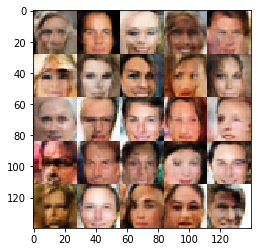

Epoch 1/1 - Batch 6310/6331:  Discriminator loss = 1.4208  Generator loss = 0.4883
Epoch 1/1 - Batch 6320/6331:  Discriminator loss = 0.7532  Generator loss = 1.3619
Epoch 1/1 - Batch 6330/6331:  Discriminator loss = 1.0979  Generator loss = 0.8324


In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.